In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os

In [2]:
import pandas as pd
import os

def load_and_process_csv(path, term_in_file='PMTrans'):
    # List to hold individual DataFrames with hierarchical indices
    dfs = []
    is_PMNN = term_in_file in ['h4q', 'tbqq']  # Check for PMNN cases
    is_PMNN_test = term_in_file in ['h4q_test', 'tbqq_test']  # Check for test variants

    # List all CSV files in the given directory
    for filename in os.listdir(path):
        
        # Only process files ending with '.csv' and matching the term_in_file conditions
        if filename.endswith('.csv') and term_in_file in filename:
            # Ensure that '_test' is not in filename when term_in_file is 'h4q' or 'tbqq'
            if (is_PMNN and '_test' not in filename) or is_PMNN_test or (term_in_file not in ['h4q', 'tbqq']):
                # Split the filename by '_'
                temp_filename = filename
                if 'h4q_test' in filename:
                    temp_filename = filename.replace('h4q_test', 'h4q-test')
                elif 'tbqq_test' in filename:
                    temp_filename = filename.replace('tbqq_test', 'tbqq-test')

                parts = temp_filename.split('_')
                
                if parts[3] == 'PMTrans':
                    start_dim = 4
                else:
                    start_dim = 3
#                 if len(parts) == 9 or len(parts) == 11:
#                     start_dim = 4
#                 else:
#                     start_dim = 3

                if is_PMNN or is_PMNN_test:
                    start_dim += 1

                # Extract particle and jet information
                particle_geom = parts[start_dim]
                particle_dim = int(parts[start_dim + 1])
                if 'x' in particle_geom:
                    particle_dim *= 2

                if not (is_PMNN or is_PMNN_test):
                    jet_geom = parts[start_dim + 2]
                    jet_dim = int(parts[start_dim + 3])
                    if 'x' in jet_geom:
                        jet_dim *= 2

                # Load the CSV into a DataFrame
                df = pd.read_csv(os.path.join(path, filename))

                # Create a MultiIndex for this DataFrame
                if is_PMNN or is_PMNN_test:
                    index_tuples = [(particle_geom, particle_dim)] * len(df)
                    index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim'])
                else:
                    index_tuples = [(particle_geom, particle_dim, jet_geom, jet_dim)] * len(df)
                    index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])

                # Assign the MultiIndex to the DataFrame
                df.index = index
                df['name'] = filename

                # Append the DataFrame to the list
                dfs.append(df)
    
    # Concatenate all DataFrames into one, maintaining the hierarchical index
    combined_df = pd.concat(dfs)
    
    return combined_df


In [3]:
import matplotlib.pyplot as plt

def correct_string_to_latex(s):
    # Split the string by underscores to handle multiple terms
    terms = s.split('x')
    temp_str = ''
    # Transform each term into LaTeX format with superscripts
    latex_terms = []
    
    i = 0
    while i < len(terms):
        
        base = terms[i]
        latex_term = f"\\mathbb{{{base.capitalize()}}}"
        i = i + 1
        temp_str = temp_str + latex_term
        if len(terms) > i:
            temp_str = temp_str + ' \\times '
    
    # Join terms with the LaTeX product symbol if there are multiple terms
    latex_string = ' \\times '.join(latex_terms)
    
    return f"${temp_str}$"

def plot_highest_accuracies(df, 
                            variable_to_vary, 
                            metric_column='acc', 
                            filter_values=None, 
                            acc_range = None,
                            title = None,
                            PMNN = False,
                            plot_trans_params = False,
                            hide_fig = False,
                            plot_best = False, 
                            shaded_plot = False, 
                            shade_by_range = False, 
                            shade_by_std = False, 
                            top_3 = False, 
                            middle_3 = False,
                            filter_name = ['none']):
    # Identify the columns that will remain constant
    leg_title = ''
    if not PMNN:
        remaining_columns = ['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']
    else:
        remaining_columns = ['particle_geom', 'particle_dim']
        
    remaining_columns.remove(variable_to_vary)
    
    colormap1 = plt.get_cmap('Set2', 6)  # 'viridis' is an example
    colormap2 = plt.get_cmap('Set1', 6)
    color_dict = {
        'R': colormap1(0),    # First color
        'RxH': colormap1(1),  # Second color
        'RxS': colormap1(2),
        'H': colormap1(3),
        'S': colormap1(4),
        'HxS': colormap1(5),
        'RxR': colormap2(0),
        'HxH': colormap2(1),
        'SxS': colormap2(2)
    }

    if filter_values:
        indexer = pd.IndexSlice
        for col, val in filter_values.items():
            if val == 'match' and col in ['particle_geom', 'jet_geom']:
                # Select rows where 'particle_geom' and 'jet_geom' are the same
                df = df[df.index.get_level_values('particle_geom') == df.index.get_level_values('jet_geom')]
            else:
                # Regular filtering based on the provided value
                df = df[df.index.get_level_values(col) == val]



    # Group by the remaining columns and the variable_to_vary
    grouped = df.groupby(remaining_columns)
    out_data = {}
    # Plot each group
    plt.figure(figsize=(10, 8),facecolor='white')
    for name, group in grouped:
            
            if PMNN: 
                if name in filter_name:
                    continue
                raw_name = name
                name = correct_string_to_latex(name)
                
                leg_title = 'Particle-Level Geom.'
            else:
                if 'particle_geom' in filter_values:
                    if name[-1] in filter_name:
                        continue
                    raw_name = name[-1]
                    name = correct_string_to_latex(name[-1]) 
                    
                    leg_title = 'Jet-Level Geom.'
                else:
                    if name[0] in filter_name:
                        continue
                    raw_name = name[0]
                    name = correct_string_to_latex(name[0]) 
                    leg_title = 'Particle-Level Geom.'

            # Find the maximum accuracy for each unique value in the variable_to_vary column
            if PMNN:
                max_values = group.groupby(['name', variable_to_vary])[metric_column].max()
                max_values = max_values.drop(columns=['name'])
#                 max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.nlargest(2).mean())
                max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.max())
                max_std = max_values.groupby(variable_to_vary).apply(lambda x: x.std())
                absolute_max_accuracy = group.groupby(variable_to_vary)[metric_column].max()
            else:
                max_values = group.groupby(['name', variable_to_vary])[metric_column].max()
                max_values = max_values.drop(columns=['name'])
                max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.max())
                absolute_max_accuracy = group.groupby(variable_to_vary)[metric_column].max()
                if middle_3:
                    max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.sort_values().iloc[len(x) // 2 - 1 : len(x) // 2 + 2].mean())
                    max_std = max_values.groupby(variable_to_vary).apply(lambda x: x.sort_values().iloc[len(x) // 2 - 1 : len(x) // 2 + 2].std())
                elif top_3:
                    max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.nlargest(3).mean())
                    max_std = max_values.groupby(variable_to_vary).apply(lambda x: x.nlargest(3).std())
                else:
                    max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.max())
                    max_std = max_values.groupby(variable_to_vary).apply(lambda x: x.std())
                
                if shaded_plot:
                    absolute_min_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.min())

            # Plot the data
            if plot_trans_params:
                PM_model_sizes ={ 
                        '32': 23.85,
                        '48': 46.03,
                        '64': 76.48,
                        '96': 162.14,
                        '128': 280.82,
                        '160': 466.28,
                        '176': 560.69,
                        '200': 718.75,
                        '240': 1040,
                        '192': 1010,
                        '256': 1090}
                M_model_sizes ={
                        '16': 14.28,
                        '32': 41.03,
                        '48':84.48,
                        '64': 144.64 ,
                        '96': 315.06,
                        '128': 552.3, 
                        '144': 695.98,
                        '160': 856.36,
                        '256': 2170}
                model_dims = max_accuracy.index

                if 'times' in name:
                    model_params = [PM_model_sizes[str(m)] for m in model_dims]
                else:
                    model_params = [M_model_sizes[str(m)] for m in model_dims]
                
                if plot_best:
                    plt.plot(model_params, 100*absolute_max_accuracy.values,linestyle = '--', color = color_dict[raw_name])
                
#                 if shaded_plot:
#                     plt.plot(model_params, 100*max_accuracy.values,
#              marker='o', label=f"{name}", color=color_dict[raw_name])
#                     if shade_by_std:
#                         plt.fill_between(model_params, 
#                                          100*max_accuracy.values - 100*max_std.values,
#                                          100*max_accuracy.values + 100*max_std.values, color=color_dict[raw_name], alpha=0.2)
#                     elif shade_by_range:
#                         plt.fill_between(model_params, 
#                                          100*absolute_min_accuracy,
#                                          100*absolute_max_accuracy, color=color_dict[raw_name], alpha=0.2)

#                 else:
#                     plt.errorbar(model_params, 100*max_accuracy.values, yerr=100*max_std.values, 
#              marker='o', label=f"{name}", color=color_dict[raw_name], capsize=3)
#                 out_data[name]= [model_params,100*max_accuracy.values]

            else:
                if plot_best:
                    plt.plot(max_accuracy.index, 100*absolute_max_accuracy.values, color = color_dict[raw_name],
                    label=f"{name}",marker='o')
                
                
                
#                 if shaded_plot:
#                     plt.plot(max_accuracy.index, 100*max_accuracy.values,
#              marker='o', label=f"{name}", color=color_dict[raw_name])
#                     if shade_by_std:
#                         plt.fill_between(max_accuracy.index, 
#                                          100*max_accuracy.values - 100*max_std.values,
#                                          100*max_accuracy.values + 100*max_std.values, color=color_dict[raw_name], alpha=0.2)
#                     elif shade_by_range:
#                         plt.fill_between(max_accuracy.index,
#                                          100*absolute_min_accuracy,
#                                          100*absolute_max_accuracy, color=color_dict[raw_name], alpha=0.2)

#                 else:
#                     plt.errorbar(max_accuracy.index, 100*max_accuracy.values, yerr=100*max_std.values, 
#              marker='o', label=f"{name}", color=color_dict[raw_name], capsize=3)
#                 plt.errorbar(max_accuracy.index, 100*max_accuracy.values, yerr=100*max_std.values, 
#              marker='o', label=f"{name}", color=color_dict[raw_name], capsize=3)

                out_data[name]= [max_accuracy.index, 100*max_accuracy.values]
            
    if plot_trans_params:
        y_label = 'Model Parameteters (k)'
    else:    
        if variable_to_vary == 'particle_dim':
            y_label = 'Particle-Level Dim'
        else:
            y_label = 'Jet-Level Dim'

    plt.xlabel(y_label)
    plt.ylabel('Accuracy (%)')
        
    plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)
    plt.grid(True)
    plt.tight_layout()
    if PMNN:
        plt.xscale('log', base=2)
    if acc_range is not None:
        plt.ylim(*acc_range)
    if not hide_fig:
        plt.show()  # Only show if hide_fig is False
    else:
        plt.close()
    return out_data

In [318]:
param_map = result_df[['name','params']]
param_map['name'] = result_df['name'].str[33:].str.split('_redo').str[0]
param_map = param_map.set_index(['name'])
param_map = param_map.to_dict()


In [9]:
df.keys()

Index(['label', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_energy', 'jet_mass',
       'jet_nparticles', 'part_px', 'part_py', 'part_pz', 'part_energy',
       'part_deta', 'part_dphi'],
      dtype='object')

In [1]:
import awkward as ak
import pandas as pd
import sys
import os

weaver_core_path = os.path.abspath("../weaver-core/weaver")
sys.path.insert(0, weaver_core_path)

# Now import the required modules
from utils.dataset import _finalize_inputs, DataConfig

# File paths
parquet_file = '/n/holystore01/LABS/iaifi_lab/Lab/nswood/TopLandscape/test_file.parquet'
config_file = 'data/TopLandscape/top_kin.yaml'

# Load data from Parquet file
df = pd.read_parquet(parquet_file).head(100000)



In [35]:
# Convert DataFrame to a list of dictionaries
records = df.to_dict('records')

# Create the Awkward Array
ak_array = ak.from_iter(records)


# Load data configuration
data_config = DataConfig.load(config_file)
from utils.dataset import _preprocess, DataConfig

# Define options for preprocessing
options = {
    'training': False,        # True for training, False for testing
    'shuffle': False,         # Shuffle the data
    'reweight': False,       # Reweighting is optional
    'up_sample': True,       # Upsample if necessary
    'weight_scale': 1,       # Weight scaling factor
    'max_resample': 10,      # Maximum resampling iterations
}

processed_data, indices = _preprocess(ak_array, data_config, options)
pf_data = processed_data['_pf_features'].transpose(0,2,1)
pf_mask = processed_data['_pf_mask'].transpose(0,2,1)
cur_data = pf_data[0]
cur_mask = pf_mask[0,:,0].astype(bool)
cur_data= cur_data[cur_mask]

In [63]:
import uproot
def read_root_file(file_path):
    with uproot.open(file_path) as file:
        # Assuming the tree name is the first key in the file
        tree = file[file.keys()[0]]
        # Convert the tree to an awkward array
        data = tree.arrays(library='ak')
    # Convert the awkward array to an Arrow table, then to a Pandas DataFrame
    arrow_table = ak.to_arrow_table(data)
    return arrow_table.to_pandas()

In [65]:
test_path = '/n/holystore01/LABS/iaifi_lab/Lab/nswood/training/TopLandscape/PMTrans/20241205-061806_example_PMTransformer_34572cf6ff96687d980a950698050b91_r_adam_lr0.0005_batch128PMTrans_RxH_4_RxH_4_partD8_jetD8_layers1_nheads1_redo_3_smaller/predict_output/pred.root'
df = read_root_file(test_path)

In [48]:
jet_pt, jet_eta, jet_label = processed_data['jet_pt'], processed_data['jet_eta'],processed_data['_label_']

In [273]:
gromov_data = pd.read_csv('top_gromov_delta_results.csv')#.head(100)
qcd_jets = df[df['jet_isQCD']]
top_jets = df[df['jet_isTop']]
common_indices = top_jets.index.intersection(gromov_data.index)

# Assign the filtered gromov_data to the new column
top_jets = top_jets.loc[common_indices]
top_jets['gromov_d'] = gromov_data['rel_delta'].loc[common_indices]

common_indices = qcd_jets.index.intersection(gromov_data.index)

# Assign the filtered gromov_data to the new column
qcd_jets = qcd_jets.loc[common_indices]
qcd_jets['gromov_d'] = gromov_data['rel_delta'].loc[common_indices]


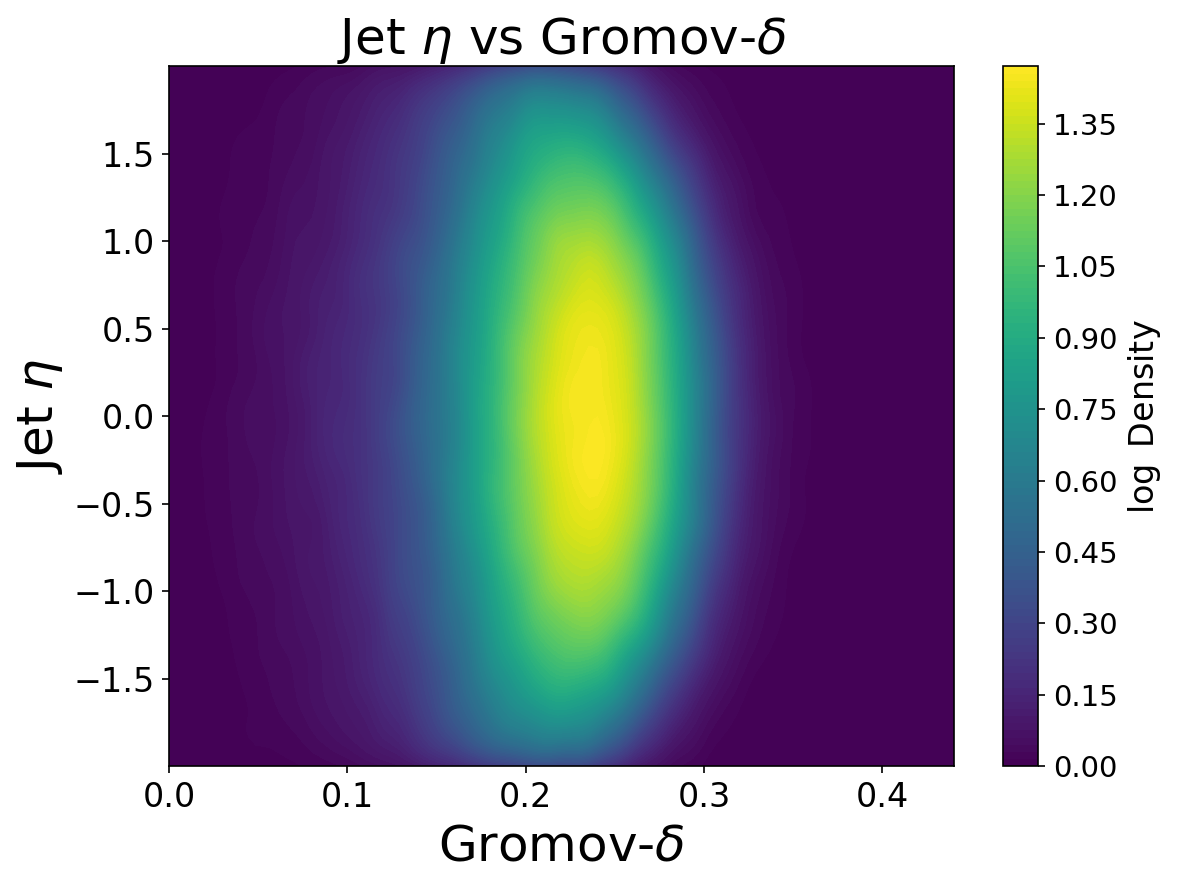

In [416]:
rel_delta = gromov_data['rel_delta']
jet_pt = gromov_data['jet_eta']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
jet_pt = jet_pt[mask]

x = rel_delta
y = jet_pt

# Define grid points for smooth heatmap
x_grid = np.linspace(x.min(), x.max(), 100)
y_grid = np.linspace(y.min(), y.max(), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Perform KDE
kde = gaussian_kde([x, y])
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()]))
z = np.log1p(z) 
# Reshape the KDE output for plotting
z = z.reshape(x_mesh.shape)

# Plot the smooth heatmap
fig = plt.figure(figsize=(8, 6),dpi=150)
fig.patch.set_facecolor('white')
plt.contourf(x_mesh, y_mesh, z, levels=100, cmap='viridis')

colorbar =plt.colorbar(label='Density')
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label(f'$\log$ Density', size=16)  
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)

# Labels and title
plt.xlabel(f'Gromov-$\\delta$', fontsize=24)
plt.ylabel(f'Jet $\\eta$', fontsize=24)
plt.title(f'Jet $\\eta$ vs Gromov-$\\delta$', fontsize=24)

plt.tight_layout()
plt.show()
# Labels

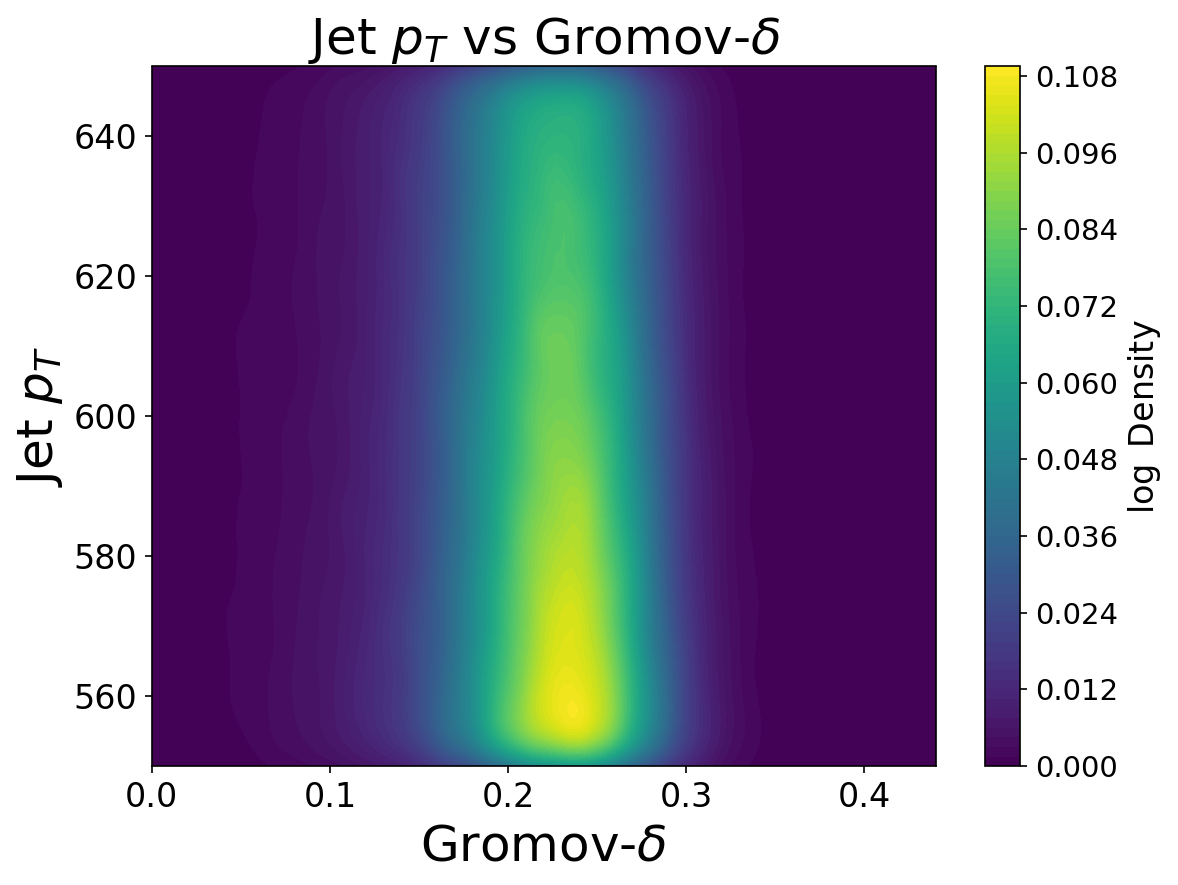

In [415]:
rel_delta = gromov_data['rel_delta']
jet_pt = gromov_data['jet_pt']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
jet_pt = jet_pt[mask]

x = rel_delta
y = jet_pt

# Define grid points for smooth heatmap
x_grid = np.linspace(x.min(), x.max(), 100)
y_grid = np.linspace(y.min(), y.max(), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Perform KDE
kde = gaussian_kde([x, y])
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()]))
z = np.log1p(z) 
# Reshape the KDE output for plotting
z = z.reshape(x_mesh.shape)

# Plot the smooth heatmap
fig = plt.figure(figsize=(8, 6),dpi=150)
fig.patch.set_facecolor('white')
plt.contourf(x_mesh, y_mesh, z, levels=100, cmap='viridis')

colorbar =plt.colorbar(label='Density')
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label(f'$\log$ Density', size=16)  
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)


# Labels and title
plt.xlabel(f'Gromov-$\\delta$', fontsize=24)
plt.ylabel(f'Jet $p_T$', fontsize=24)
plt.title(f'Jet $p_T$ vs Gromov-$\\delta$', fontsize=24)

plt.tight_layout()
plt.show()
# Labels

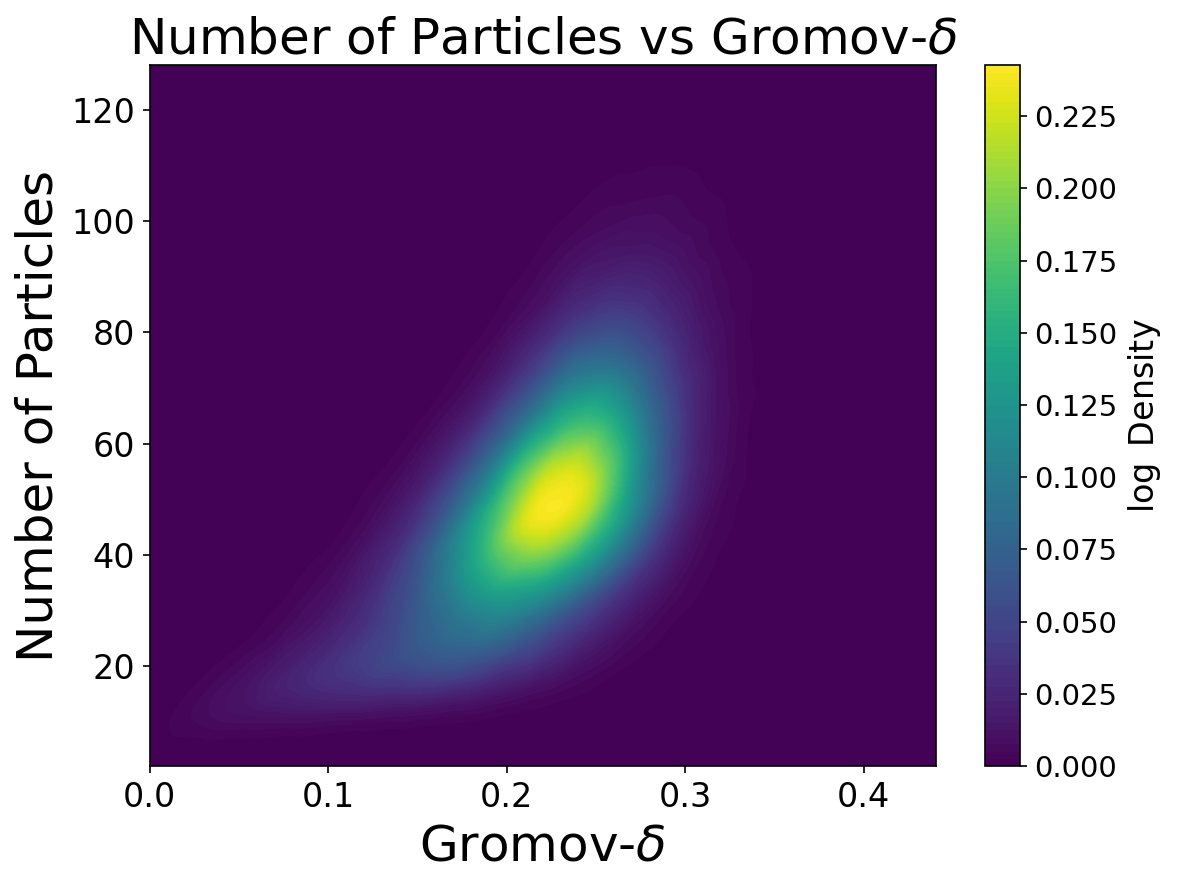

In [414]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Assuming rel_delta and jet_pt are defined
rel_delta = gromov_data['rel_delta']
jet_pt = gromov_data['jet_nparts']

# Remove NaN values
mask = ~np.isnan(rel_delta)
rel_delta = rel_delta[mask]
jet_pt = jet_pt[mask]

# Create a 2D grid for KDE
x = rel_delta
y = jet_pt

# Define grid points for smooth heatmap
x_grid = np.linspace(x.min(), x.max(), 100)
y_grid = np.linspace(y.min(), y.max(), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Perform KDE
kde = gaussian_kde([x, y])
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()]))
z = np.log1p(z) 
# Reshape the KDE output for plotting
z = z.reshape(x_mesh.shape)

# Plot the smooth heatmap
fig = plt.figure(figsize=(8, 6),dpi=150)
fig.patch.set_facecolor('white')
plt.contourf(x_mesh, y_mesh, z, levels=100, cmap='viridis')
colorbar =plt.colorbar(label='Density')
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label(f'$\log$ Density', size=16)  
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)

# Labels and title
plt.xlabel(f'Gromov-$\\delta$', fontsize=24)
plt.ylabel(f'Number of Particles', fontsize=24)
plt.title(f'Number of Particles vs Gromov-$\\delta$', fontsize=24)

plt.tight_layout()
plt.show()


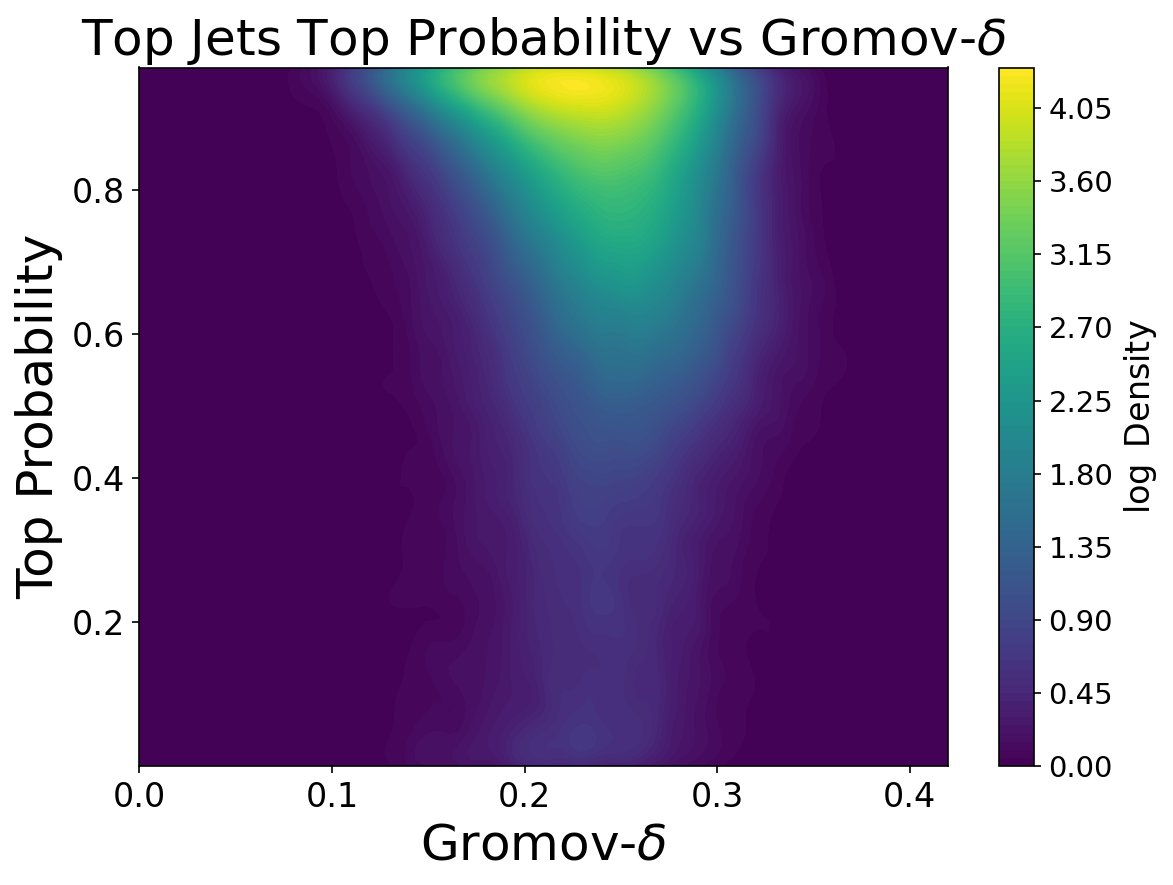

In [413]:
rel_delta = top_jets['gromov_d']
top_pred = top_jets['score_jet_isTop']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
top_pred = top_pred[mask]

# Create a 2D grid for KDE
x = rel_delta
y = top_pred

# Define grid points for smooth heatmap
x_grid = np.linspace(0, 0.42, 100)
y_grid = np.linspace(y.min(), y.max(), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Perform KDE
kde = gaussian_kde([x, y])
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()]))
z = np.log1p(z) 
# Reshape the KDE output for plotting
z = z.reshape(x_mesh.shape)

# Plot the smooth heatmap
fig = plt.figure(figsize=(8, 6),dpi=150)
fig.patch.set_facecolor('white')
plt.contourf(x_mesh, y_mesh, z, levels=100, cmap='viridis')
colorbar =plt.colorbar(label='Density')
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label(f'$\log$ Density', size=16)  
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)

# Labels and title
plt.xlabel(f'Gromov-$\\delta$', fontsize=24)
plt.ylabel(f'Top Probability', fontsize=24)
plt.title(f'Top Jets Top Probability vs Gromov-$\\delta$', fontsize=24)

plt.tight_layout()
plt.show()


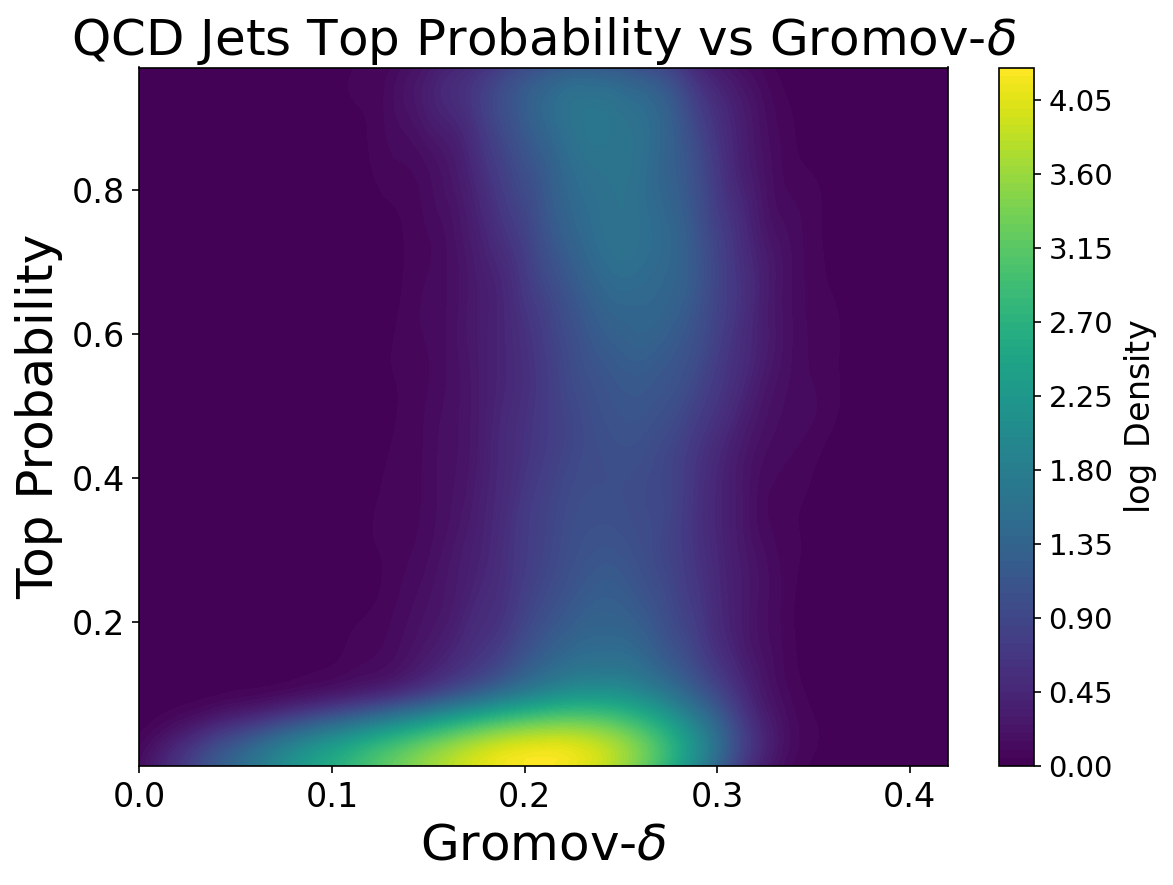

In [412]:
rel_delta = qcd_jets['gromov_d']
top_pred = qcd_jets['score_jet_isTop']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
top_pred = top_pred[mask]

# Create a 2D grid for KDE
x = rel_delta
y = top_pred

# Define grid points for smooth heatmap
x_grid = np.linspace(0, 0.42, 100)
y_grid = np.linspace(y.min(), y.max(), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Perform KDE
kde = gaussian_kde([x, y])
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()]))

z = np.log1p(z) 

# Reshape the KDE output for plotting
z = z.reshape(x_mesh.shape)

# Plot the smooth heatmap
fig = plt.figure(figsize=(8, 6),dpi=150)
fig.patch.set_facecolor('white')
plt.contourf(x_mesh, y_mesh, z, levels=100, cmap='viridis')
colorbar =plt.colorbar(label='Density')
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label(f'$\log$ Density', size=16)  
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# Labels and title
plt.xlabel(f'Gromov-$\\delta$', fontsize=24)
plt.ylabel(f'Top Probability', fontsize=24)
plt.title(f'QCD Jets Top Probability vs Gromov-$\\delta$', fontsize=24)

plt.tight_layout()
plt.show()


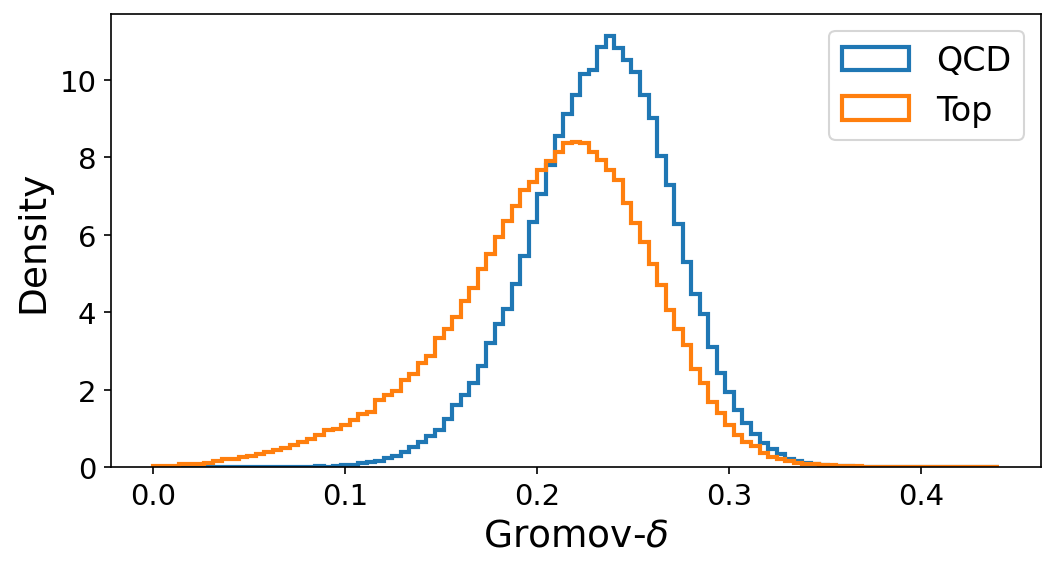

In [410]:

top_jets_gromov_d = top_jets['gromov_d']
qcd_jets_gromov_d = qcd_jets['gromov_d']

# Define common bins
bins = np.linspace(min(top_jets_gromov_d.min(), qcd_jets_gromov_d.min()),
                   max(top_jets_gromov_d.max(), qcd_jets_gromov_d.max()), 100)

# Plot the histograms
fig = plt.figure(figsize=(8, 4), dpi=150)
plt.hist(top_jets_gromov_d, bins=bins, histtype='step', label='QCD',density = True,linewidth=2)
plt.hist(qcd_jets_gromov_d, bins=bins, histtype='step', label='Top',density = True,linewidth=2)

# Add labels and legend
plt.legend(fontsize = 16)
plt.xlabel(r'Gromov-$\delta$', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)

# Set figure background color
fig.patch.set_facecolor('white')

# Show the plot
plt.show()


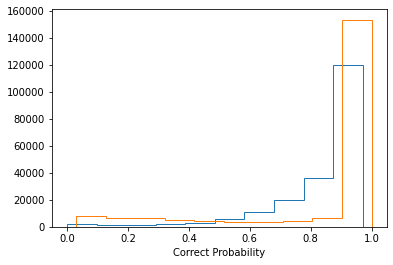

In [330]:
plt.hist(top_jets['score_jet_isTop'],histtype = 'step',label = 'QCD')
plt.hist(qcd_jets['score_jet_isQCD'],histtype = 'step',label = 'Top')
plt.xlabel('Correct Probability')
plt.show()


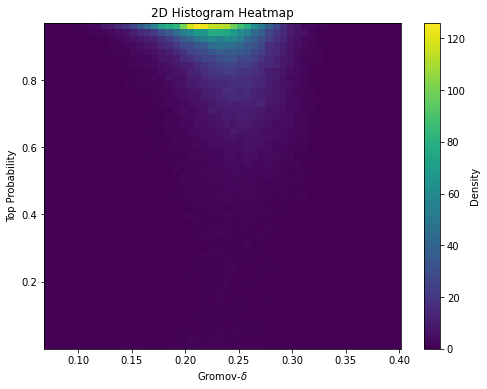

In [193]:
rel_delta = top_jets['gromov_d']
top_pred = top_jets['score_jet_isTop']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
top_pred = top_pred[mask]

# Create a 2D histogram
plt.figure(figsize=(8, 6))
heatmap, xedges, yedges, im = plt.hist2d(rel_delta, top_pred, bins=50, cmap='viridis', density=True)

# Add a colorbar
plt.colorbar(im, label='Density')

# Labels
plt.xlabel(f'Gromov-$\\delta$')
plt.ylabel(f'Top Probability')
plt.title('2D Histogram Heatmap')

plt.show()


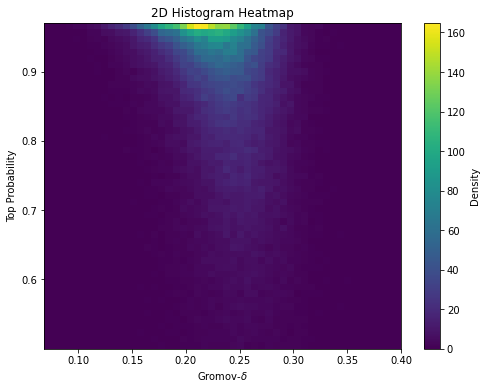

In [200]:
rel_delta = top_jets['gromov_d']
top_pred = top_jets['score_jet_isTop']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
top_pred = top_pred[mask]

mask = top_pred > 0.5

rel_delta = rel_delta[mask]
top_pred = top_pred[mask]

## how to normalize this by gromov_data['rel_delta'] in the x direction.


# Create a 2D histogram
plt.figure(figsize=(8, 6))
heatmap, xedges, yedges, im = plt.hist2d(rel_delta, top_pred, bins=50, cmap='viridis', density=True)

# Add a colorbar
plt.colorbar(im, label='Density')

# Labels
plt.xlabel(f'Gromov-$\\delta$')
plt.ylabel(f'Top Probability')
plt.title('2D Histogram Heatmap')

plt.show()

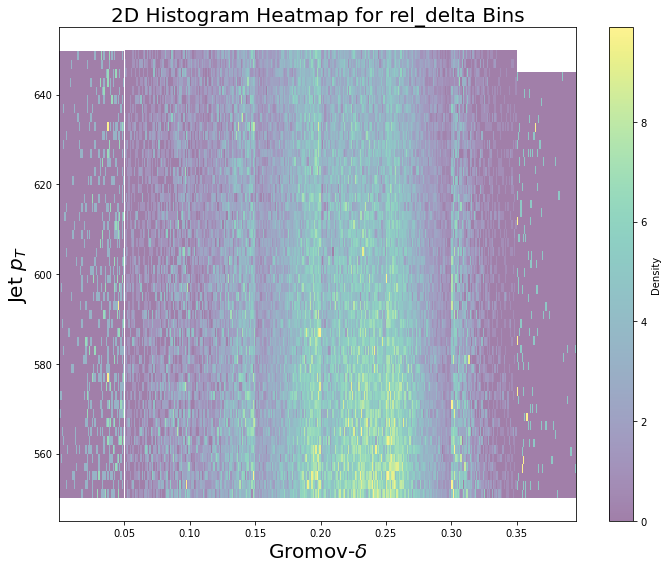

In [163]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace these with gromov_data['rel_delta'] and gromov_data['jet_pt'])
rel_delta = gromov_data['rel_delta']
jet_pt = gromov_data['jet_pt']

# Define parameters for rel_delta bins
bin_width = 0.05
num_bins = int((rel_delta.max() - rel_delta.min()) / bin_width)  # Calculate the number of bins dynamically

plt.figure(figsize=(10, 8))

for i in range(num_bins):
    # Define the bin range
    bin_start = i * bin_width
    bin_end = (i + 1) * bin_width
    
    # Apply mask for the current bin
    cur_mask = (rel_delta > bin_start) & (rel_delta <= bin_end)
    
    # Check if there are points in the current bin
    if cur_mask.sum() == 0:
        continue  # Skip this bin if no data points are present
    
    # Compute the histogram and plot with contour or pcolormesh
    heatmap, xedges, yedges = np.histogram2d(
        rel_delta[cur_mask], 
        jet_pt[cur_mask], 
        bins=50, 
        density=True
    )
    
    # Plot each histogram as a heatmap using `pcolormesh`
    plt.pcolormesh(
        xedges, 
        yedges, 
        heatmap.T,  # Transpose to align correctly
        cmap='viridis', 
        alpha=0.5  # Transparency to avoid overplotting issues
    )

# Add a colorbar for reference
plt.colorbar(label='Density')

# Labels and title
plt.xlabel(f'Gromov-$\\delta$', fontsize=20)
plt.ylabel(f'Jet $p_T$', fontsize=20)
plt.title('2D Histogram Heatmap for rel_delta Bins', fontsize=20)

# Show plot
plt.tight_layout()
plt.show()


In [84]:
import numpy as np 
percentiles = [50, 75, 90, 95, 99]

# Calculate percentiles
percentile_values = np.percentile(, percentiles)
cur_mask = curvatures

In [93]:
percentiles = [50, 75, 90, 95, 99]

curvatures = gromov_data['c'].to_numpy()

percentile_values = np.percentile(curvatures, percentiles)

cur_mask = (~np.isnan(curvatures)) & (curvatures > percentile_values[0])

In [95]:
cur_mask.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

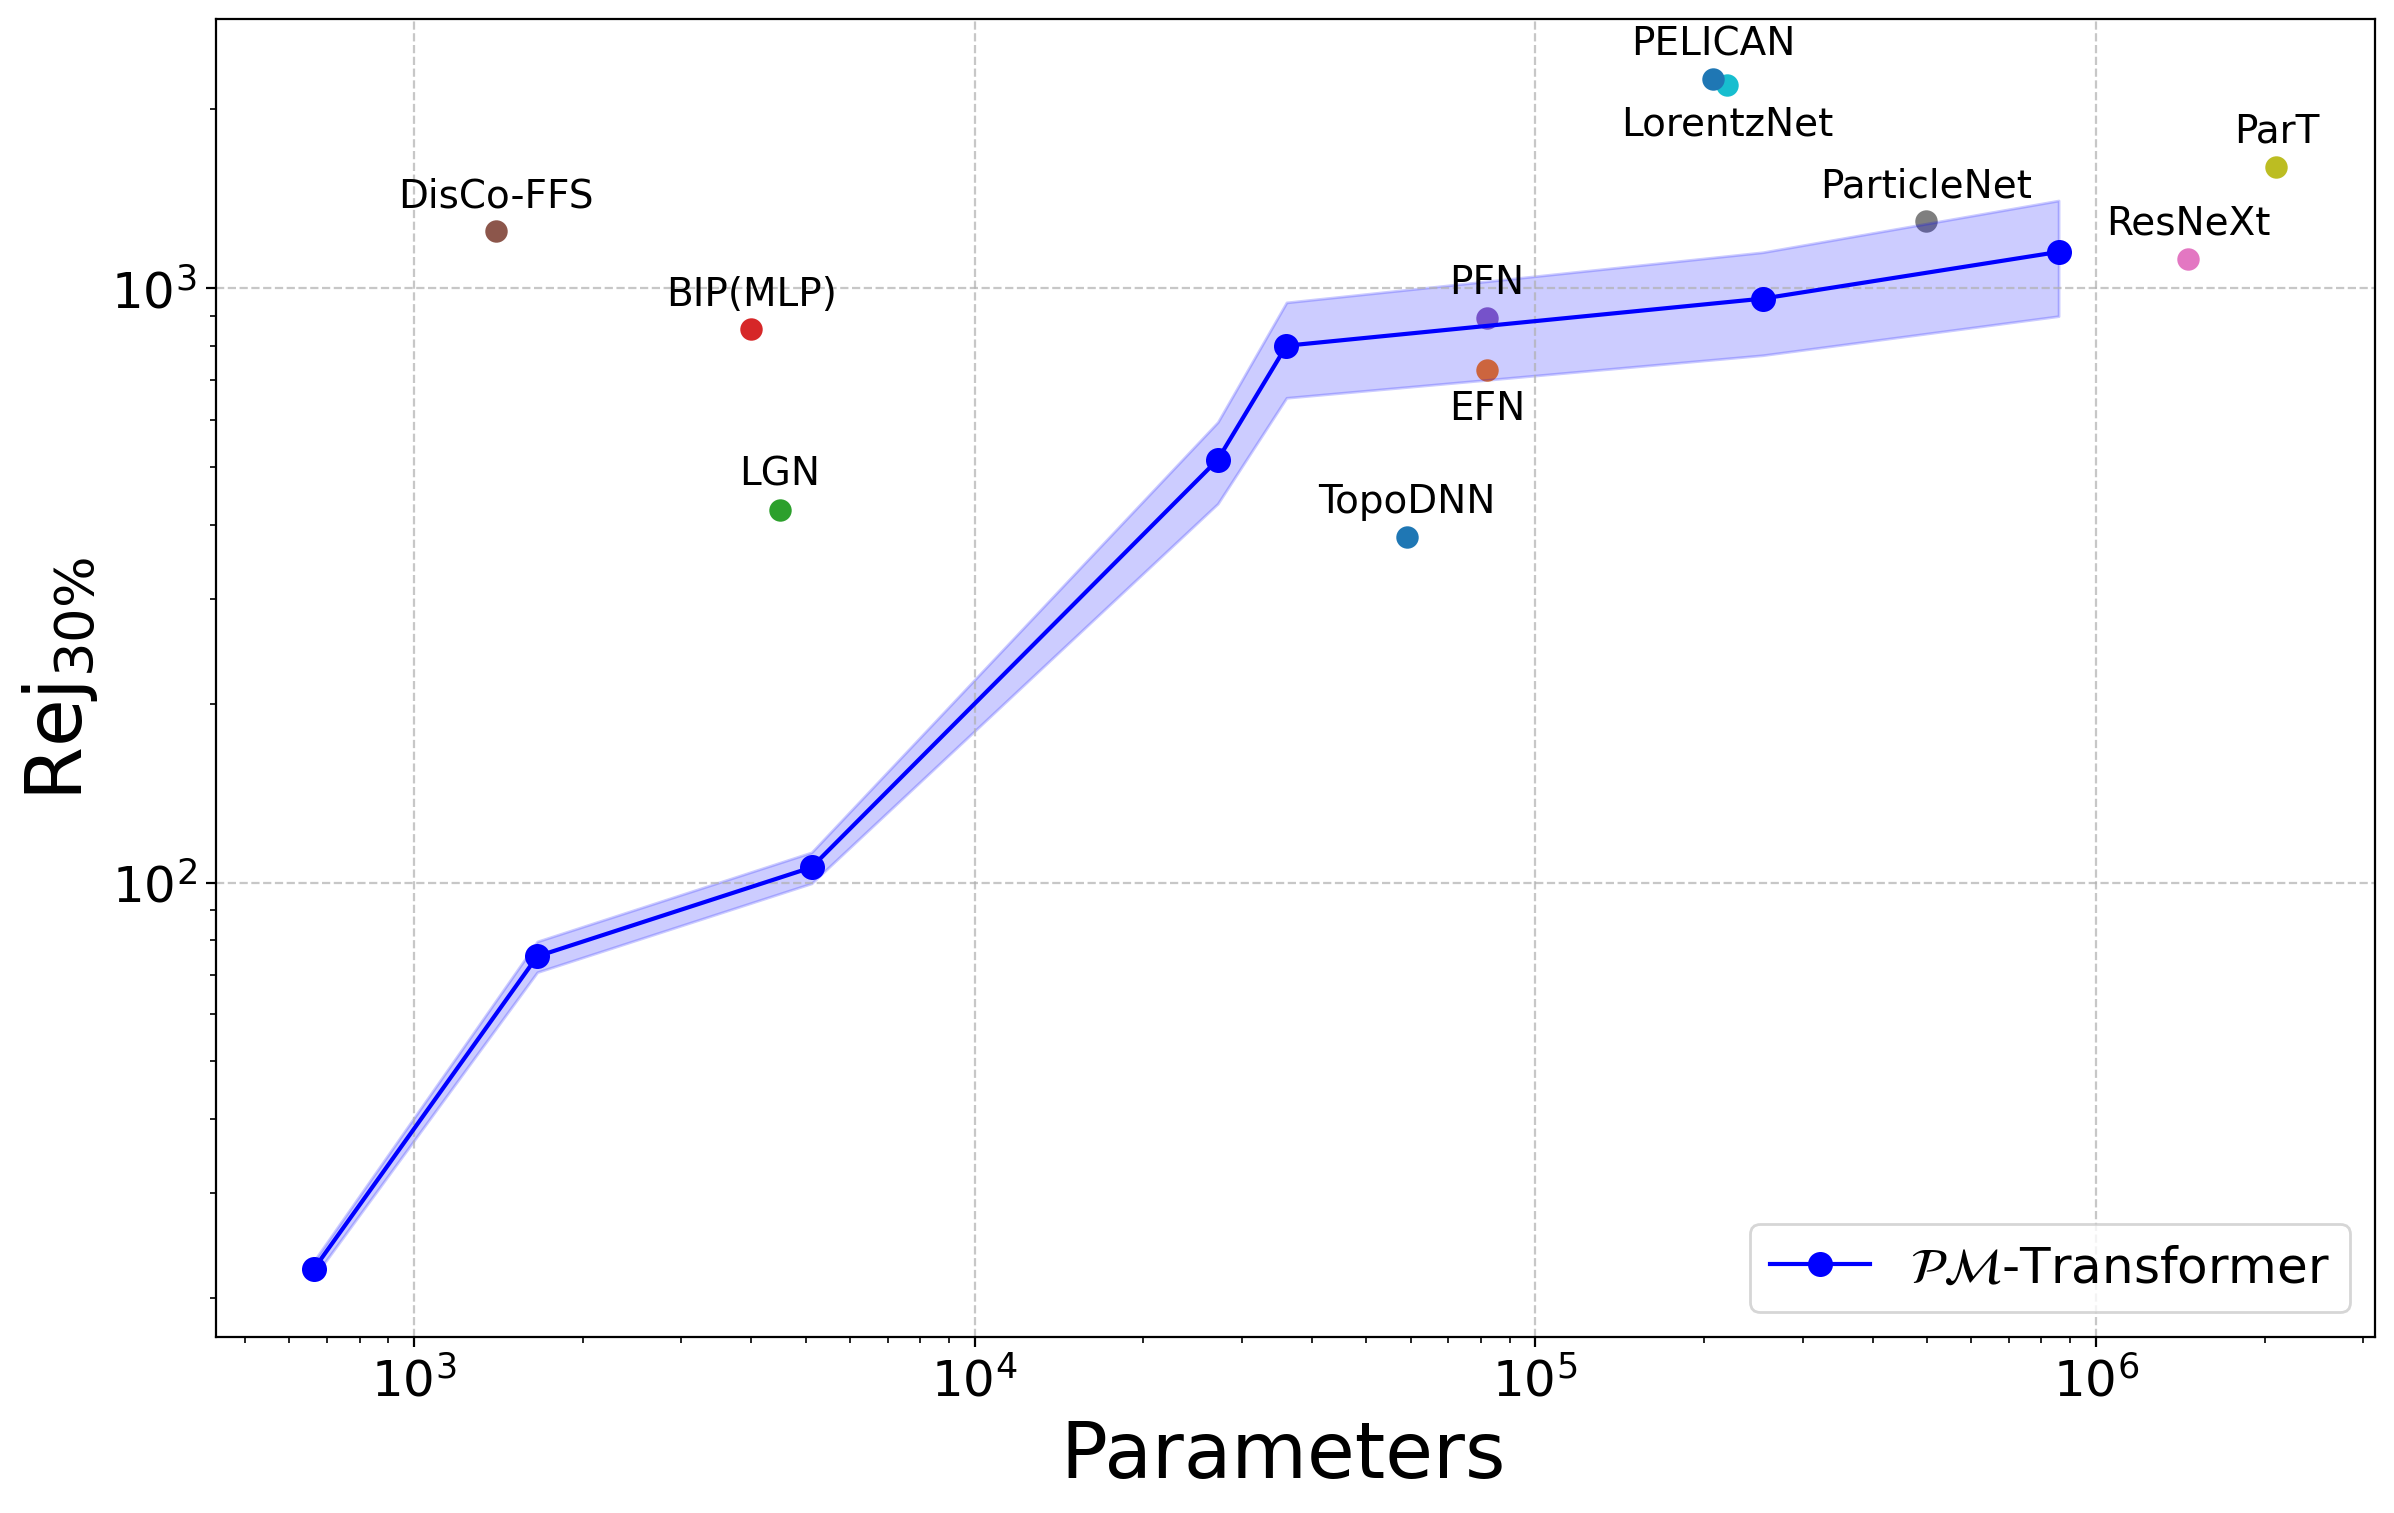

      params  overall_auc  accuracy_mean  overall_accuracy  accuracy_std  \
18     664.0     0.908910       0.861867          0.862156      0.001676   
10    1660.0     0.951785       0.899170          0.899128      0.001402   
9     5120.0     0.958407       0.903413          0.903520      0.001503   
5    27160.0     0.978248       0.926500          0.926507      0.001348   
7    36010.0     0.981249       0.930892          0.931064      0.001074   
19  254550.0     0.982586       0.934186          0.934178      0.001165   
28  858190.0     0.984272       0.937554          0.937700      0.001086   

    Top_rejection_50_mean  Top_rejection_50_std  Top_rejection_50_full  \
18              13.480469              0.291116              13.470812   
10              34.219623              1.336649              33.872505   
9               43.569433              1.742347              43.469107   
5              157.726561             12.725387             159.489731   
7              217.80

In [462]:

warnings.filterwarnings('ignore')


# Load the DataFrame
results_df = pd.read_csv('top_PMTrans_benchmark.csv').sort_values('overall_accuracy', ascending=False)

results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]

split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1,2,3,4,7,8]]
results_df[['particle_geom', 'particle_dim','jet_geom','jet_dim','layers','heads']] = split_columns
results_df['layers'] = results_df['layers'].str[-1]
results_df['heads'] = results_df['heads'].str.split('nheads').str[1]


param_map = {'RxH_2_RxH_2_partD4_jetD4_layers1_nheads1': 664.0,
  'RxH_120_RxH_128_partD240_jetD256_layers4_nheads12': 1380000.0,
  'RxH_2_RxH_6_partD4_jetD12_layers2_nheads1': 1490.0,
  'RxH_4_RxH_4_partD8_jetD8_layers1_nheads1': 1660.0,
  'RxH_5_RxH_12_partD10_jetD24_layers2_nheads1': 5120.0,
  'RxH_120_RxH_128_partD240_jetD256_layers8_nheads12': 2029999.9999999998,
  'RxH_40_RxH_48_partD80_jetD96_layers8_nheads4': 254550.0,
  'RxH_10_RxH_24_partD20_jetD48_layers2_nheads1': 27160.0,
  'RxH_10_RxH_24_partD20_jetD48_layers8_nheads1': 36010.0,
  'RxH_20_RxH_32_partD40_jetD64_layers8_nheads2': 83380.0,
  'RxH_80_RxH_64_partD160_jetD128_layers8_nheads8': 858190.0} 

# Group by the columns and select the rows with the maximum 'overall_accuracy' for each group
best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)


result = best_rows_df.sort_values(by='params')[['params','overall_auc','accuracy_mean',
                                                'overall_accuracy','accuracy_std','Top_rejection_50_mean',
                                                'Top_rejection_50_std','Top_rejection_50_full','Top_rejection_30_full',
                                                'Top_rejection_30_mean','Top_rejection_30_std',
                                               'particle_geom', 'particle_dim','jet_geom','jet_dim','layers','heads']]
result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]
# result= result[(result['params'] != 83380.0)]


# plt.figure(figsize =(10,6))
# plt.title('Top Tagging Val Accuracy')
# plt.ylabel('Val Acc')
# plt.xlabel('Model Trainable Parameters')
# plt.plot(result['params'].to_numpy(),result['val_acc'].to_numpy())
# plt.xscale('log')
# # plt.ylim(0.92,0.95)

# # plt.xlim(2*1e4,2*1e6)
# plt.show()

# Manually input the data
data = {
    "Architecture": [
        "TopoDNN", "EFN", "LGN",  "BIP(MLP)", 
        "PFN", "DisCo-FFS", "ResNeXt", "ParticleNet", "ParT", 
        "LorentzNet", "PELICAN", 
    ],
    "Accuracy": [
        0.916, 0.927, 0.929,   0.931, 
        0.932, None, 0.936, 0.938, 0.940, 0.942, 
        0.9426, 0.9406
    ],
    "Params": [
        59000, 82000, 4500,  4000, 
        82000, 1400, 1460000, 498000, 2100000, 
        220000, 208000, 208000
    ],
    "rej_30": [
        382, 729, 424, 853, 
        891, 1249, 1122, 1298, 1602, 2195, 
        2250
    ]
}

# # Create the plot
# fig = plt.figure(figsize=(12, 8))
# for i, architecture in enumerate(data["Architecture"]):
#     x = data["Params"][i]  # Convert parameters to thousands
#     y = data["Accuracy"][i]
#     if y is not None:  # Skip missing accuracies
#         plt.scatter(x, y, label=architecture)
#         plt.text(x, y, architecture, fontsize=8, ha='right')

# # Formatting
# plt.xlabel("Parameters ", fontsize=14)
# plt.ylabel("Accuracy", fontsize=14)
# plt.plot(result['params'].to_numpy(),result['accuracy_mean'].to_numpy(),label = 'PM-Transformer')
# plt.fill_between(result['params'].to_numpy(), 
#                              (result['accuracy_mean'].to_numpy() - result['accuracy_std'].to_numpy()),
#                              (result['accuracy_mean'].to_numpy() + result['accuracy_std'].to_numpy()), 
#                              color='b', alpha=0.2)
# plt.title("Top Tagging: Accuracy vs. Parameters", fontsize=16)
# plt.grid(True, linestyle="--", alpha=0.7)
# plt.xscale('log')
# plt.tight_layout()
# plt.legend(ncol = 2)
# fig.patch.set_facecolor('white')
# # Show the plot
# plt.show()


# Create the plot
fig = plt.figure(figsize=(12, 8),dpi =200)
for i, architecture in enumerate(data["Architecture"]):
    x = data["Params"][i]  # Convert parameters to thousands
    y = data["rej_30"][i]
    if y is not None:  # Skip missing accuracies
        plt.scatter(x, y,s = 50)
        if 'Loren' in architecture or 'EFN' in architecture:
            plt.text(x, y*0.825, architecture, fontsize=14, ha='center')
        else:
            plt.text(x, y*1.1, architecture, fontsize=14, ha='center')

# Formatting
plt.xlabel("Parameters ", fontsize=28)
plt.ylabel(f"$\\text{{Rej}}_{{30\%}}$", fontsize=28)
plt.plot(result['params'].to_numpy(),result['Top_rejection_30_mean'].to_numpy(),label = f'$\mathcal{{P}}\mathcal{{M}}$-Transformer',color = 'b',marker='o', markersize = 8)
plt.fill_between(result['params'].to_numpy(), 
                             (result['Top_rejection_30_mean'].to_numpy() - result['Top_rejection_30_std'].to_numpy()),
                             (result['Top_rejection_30_mean'].to_numpy() + result['Top_rejection_30_std'].to_numpy()), 
                             color='blue', alpha=0.2)
# plt.title("Top Tagging: Rej (at 0.3) vs. Parameters", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xscale('log')
plt.tight_layout()
plt.yscale('log')
plt.legend(ncol = 1,fontsize = 18,loc = 'lower right')
ax = plt.gca()


ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=18)
fig.patch.set_facecolor('white')
# Show the plot
plt.show()

print(result)

In [292]:
all_files = os.listdir()
gromov_output = []
for file in all_files: 
    if 'gromov' in file and 'csv' in file and 'bench' in file:
        gromov_output.append(file)

/tmp/ipykernel_629729/3483712952.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


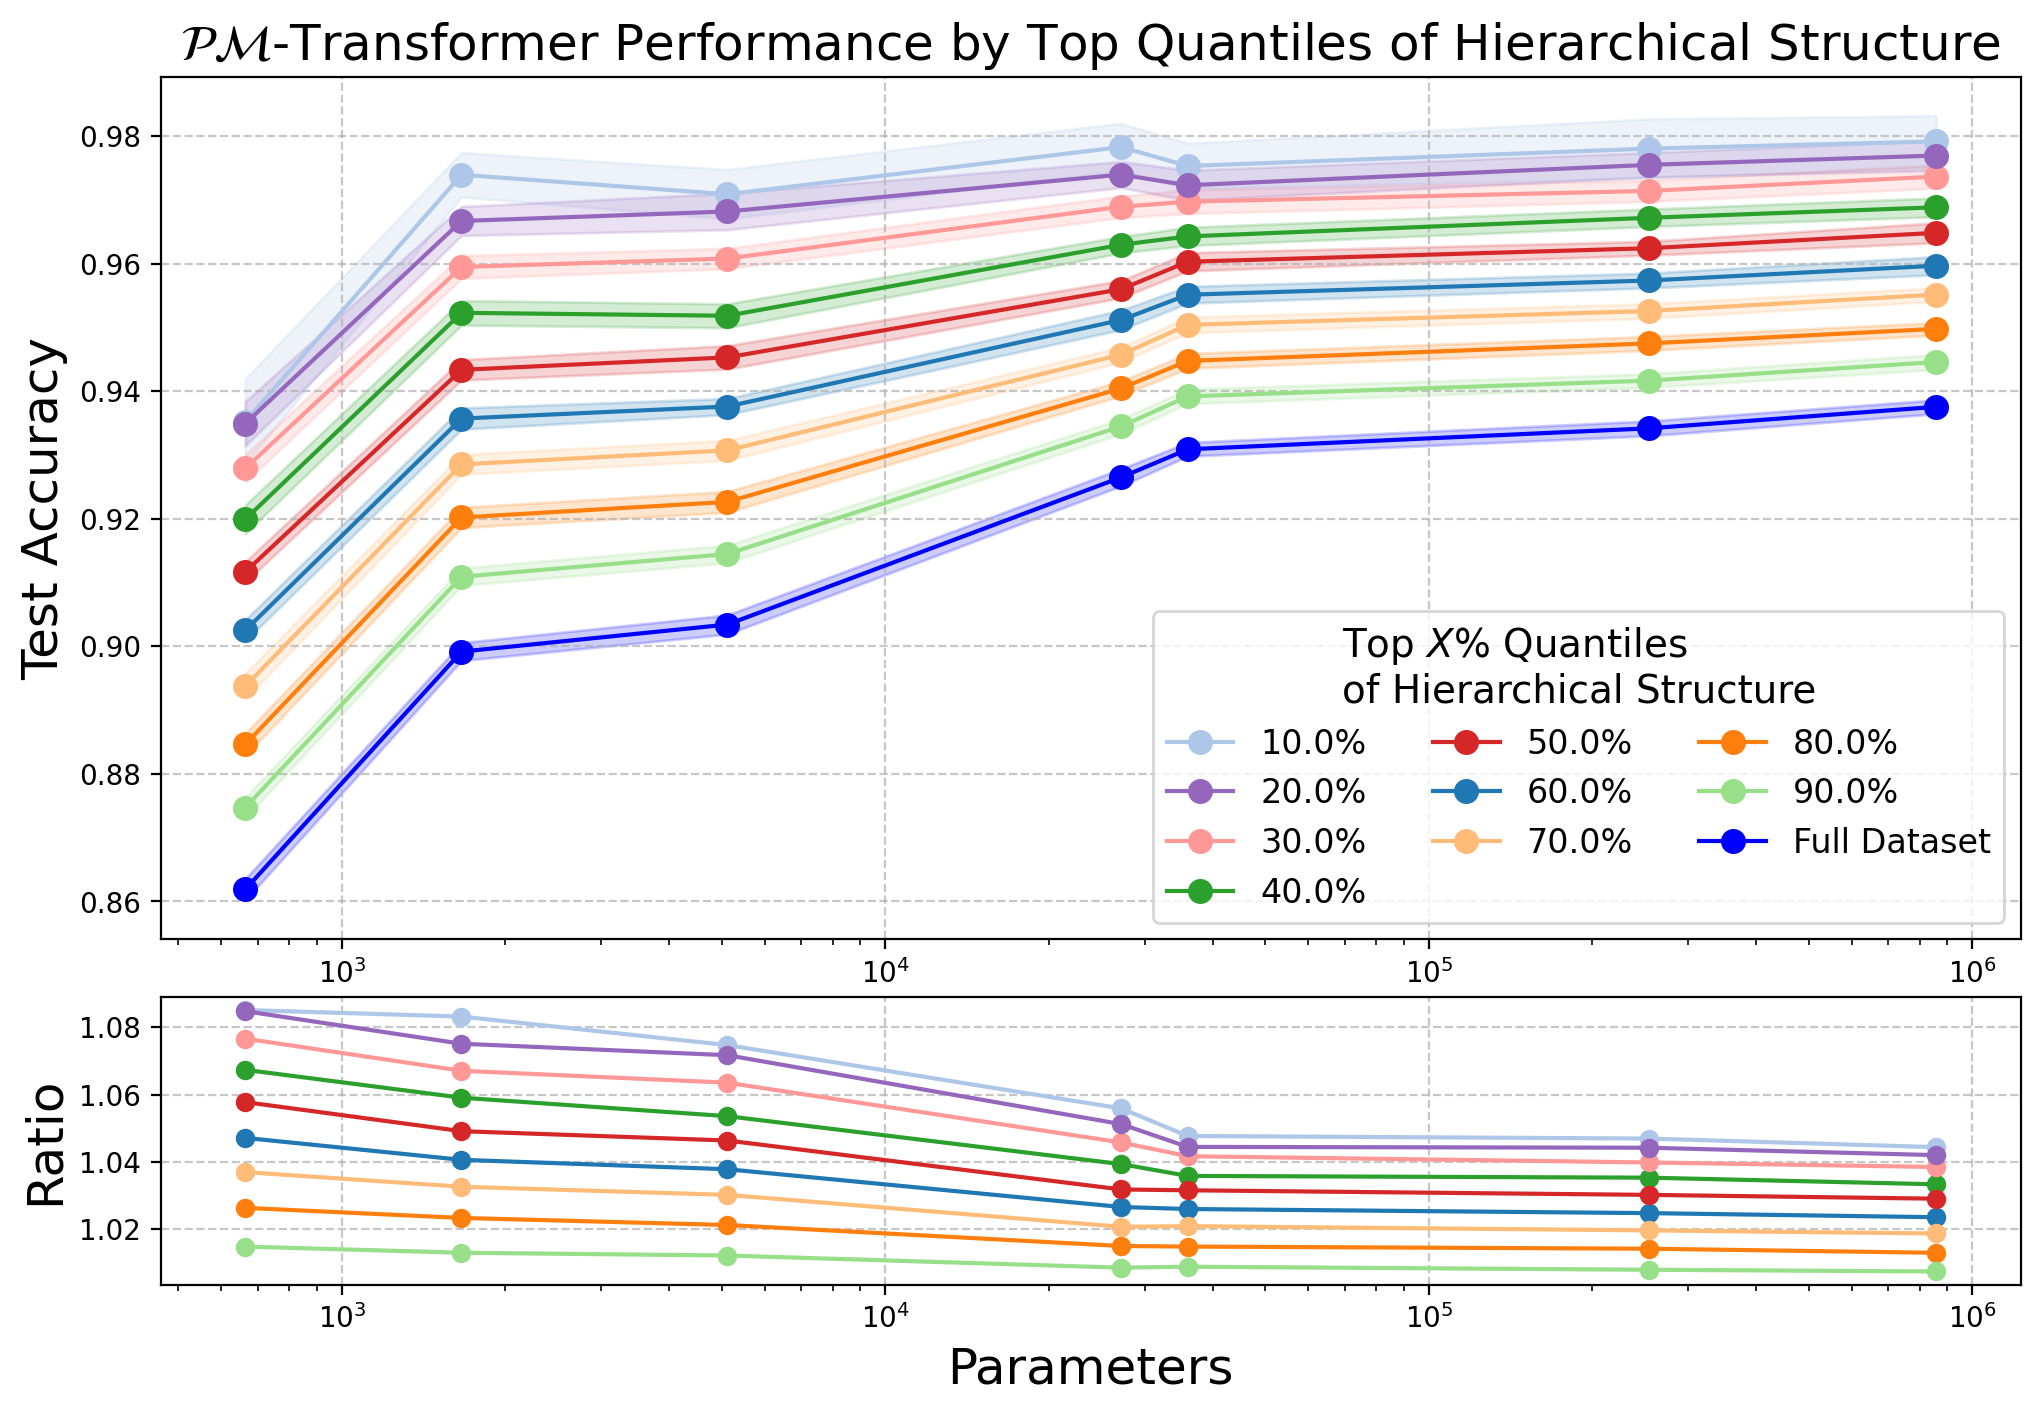

In [398]:
# Full code integrating split plot for ratio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


param_map = {
    'RxH_2_RxH_2_partD4_jetD4_layers1_nheads1': 664.0,
    'RxH_120_RxH_128_partD240_jetD256_layers4_nheads12': 1380000.0,
    'RxH_2_RxH_6_partD4_jetD12_layers2_nheads1': 1490.0,
    'RxH_4_RxH_4_partD8_jetD8_layers1_nheads1': 1660.0,
    'RxH_5_RxH_12_partD10_jetD24_layers2_nheads1': 5120.0,
    'RxH_120_RxH_128_partD240_jetD256_layers8_nheads12': 2029999.9999999998,
    'RxH_40_RxH_48_partD80_jetD96_layers8_nheads4': 254550.0,
    'RxH_10_RxH_24_partD20_jetD48_layers2_nheads1': 27160.0,
    'RxH_10_RxH_24_partD20_jetD48_layers8_nheads1': 36010.0,
    'RxH_20_RxH_32_partD40_jetD64_layers8_nheads2': 83380.0,
    'RxH_80_RxH_64_partD160_jetD128_layers8_nheads8': 858190.0
}

# Define the figure and grid specification
fig = plt.figure(figsize=(12, 8), dpi=200)
gs = fig.add_gridspec(2, 1, height_ratios=[3,1], hspace=0.1)

# Main plot (accuracy vs. parameters)
ax1 = fig.add_subplot(gs[0])
cmap = plt.cm.get_cmap('tab20')
i = 0

# Iterate through gromov_output files
for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 95 or cur_curv_percent % 10 != 0:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]


    label = f"{100 - cur_curv_percent}%"
    ax1.plot(result['params'], result['accuracy_mean'], label=label, color=cmap(i / 19), marker='o', markersize=8)
    ax1.fill_between(result['params'], 
                     result['accuracy_mean'] - result['accuracy_std'], 
                     result['accuracy_mean'] + result['accuracy_std'], 
                     color=cmap(i / 19), alpha=0.2)
    i += 1

# Full dataset plot
full_results_df = pd.read_csv('top_PMTrans_benchmark.csv').sort_values('overall_accuracy', ascending=False)
full_results_df['base_name'] = full_results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
split_columns = full_results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
full_results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
full_results_df['layers'] = full_results_df['layers'].str[-1]
full_results_df['heads'] = full_results_df['heads'].str.split('nheads').str[1]

best_full_rows_df = full_results_df.loc[full_results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
best_full_rows_df['params'] = best_full_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

full_result = best_full_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]

full_result= full_result[(full_result['params'] != 83380.0) & (full_result['params'] <= 1000000.0) & (full_result['params'] != 1490.0)]

ax1.plot(full_result['params'], full_result['accuracy_mean'], label='Full Dataset', color='b', marker='o', markersize=8)
ax1.fill_between(full_result['params'], 
                 full_result['accuracy_mean'] - full_result['accuracy_std'], 
                 full_result['accuracy_mean'] + full_result['accuracy_std'], 
                 color='b', alpha=0.2)

# Formatting for main plot
ax1.set_xscale('log')
ax1.set_ylabel("Test Accuracy", fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()

# Define a sorting key
def sorting_key(hl):
    handle, label = hl
    try:
        return (0, int(label))  # Sort numeric labels by their value
    except ValueError:
        return (1, label)       # Non-numeric labels go to the bottom

# Sort handles and labels
sorted_handles_labels = sorted(zip(handles, labels), key=sorting_key)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Add sorted legend
plt.legend(sorted_handles, sorted_labels, ncol=3, 
           fontsize=12, loc='lower right',
           title = f'Top $X$% Quantiles \nof Hierarchical Structure',
           title_fontsize = 14)


# plt.legend(ncol = 1,fontsize = 18,loc = 'lower right')
plt.title(
    r'$\mathcal{P}\mathcal{M}$-Transformer Performance by Top Quantiles of Hierarchical Structure',
    fontsize=18,  # Adjust fontsize as needed
    wrap=True     # Optional: enables auto-wrapping for long titles
)
ax1.grid(True, linestyle="--", alpha=0.7)



# Ratio plot (below the main plot)
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Reset color iterator for consistent colors in lower plot
i = 0

for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 95 or cur_curv_percent % 10 != 0:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params','auc_mean','auc_std', 'accuracy_mean', 'accuracy_std','Top_rejection_30_mean','Top_rejection_30_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]

    
    # Compute the ratio
    try:
        ratio = result['accuracy_mean'] / np.interp(result['params'], full_result['params'], full_result['accuracy_mean'])
    except Exception as e:
        print(f"Error computing ratio for {file}: {e}")
        continue

    # Plot the ratio
    ax2.plot(result['params'], ratio, label=f"{100 - cur_curv_percent}%", color=cmap(i / 19), marker='o', markersize=6)
    i += 1
#     print(f'{100 - cur_curv_percent}')
#     print(result)

# Formatting for ratio plot
ax2.set_xscale('log')
ax2.set_xlabel("Parameters", fontsize=18)
ax2.set_ylabel("Ratio", fontsize=18)
ax2.grid(True, linestyle="--", alpha=0.7)

# Set figure background
fig.patch.set_facecolor('white')

# Show the plot
plt.show()


/tmp/ipykernel_629729/4034895078.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


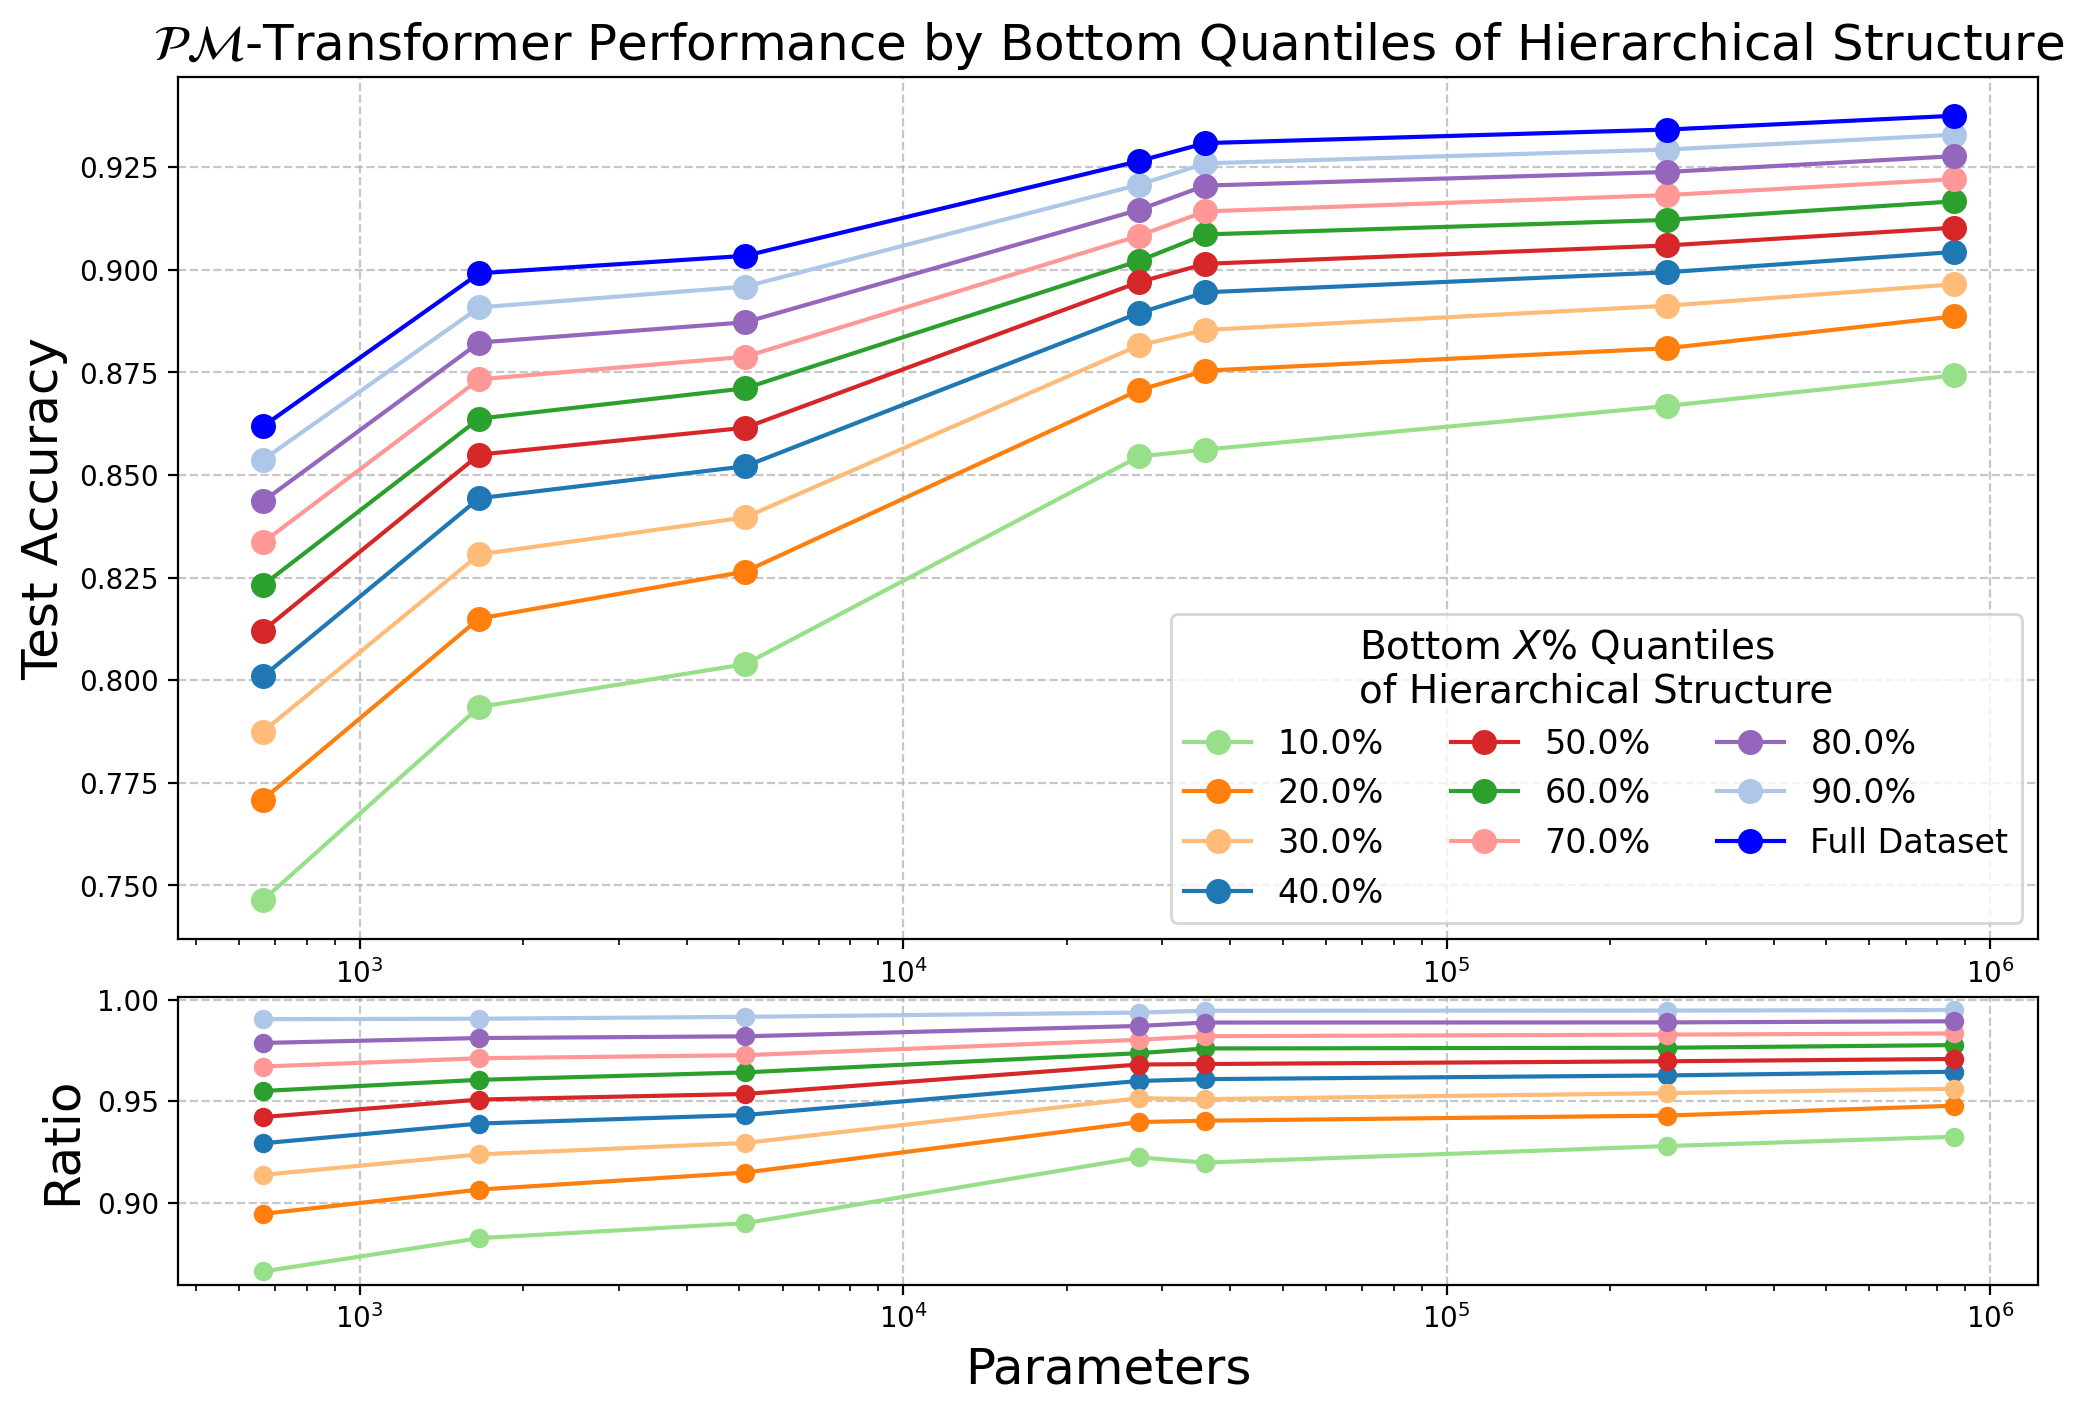

In [400]:
# Full code integrating split plot for ratio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


param_map = {
    'RxH_2_RxH_2_partD4_jetD4_layers1_nheads1': 664.0,
    'RxH_120_RxH_128_partD240_jetD256_layers4_nheads12': 1380000.0,
    'RxH_2_RxH_6_partD4_jetD12_layers2_nheads1': 1490.0,
    'RxH_4_RxH_4_partD8_jetD8_layers1_nheads1': 1660.0,
    'RxH_5_RxH_12_partD10_jetD24_layers2_nheads1': 5120.0,
    'RxH_120_RxH_128_partD240_jetD256_layers8_nheads12': 2029999.9999999998,
    'RxH_40_RxH_48_partD80_jetD96_layers8_nheads4': 254550.0,
    'RxH_10_RxH_24_partD20_jetD48_layers2_nheads1': 27160.0,
    'RxH_10_RxH_24_partD20_jetD48_layers8_nheads1': 36010.0,
    'RxH_20_RxH_32_partD40_jetD64_layers8_nheads2': 83380.0,
    'RxH_80_RxH_64_partD160_jetD128_layers8_nheads8': 858190.0
}

# Define the figure and grid specification
fig = plt.figure(figsize=(12, 8), dpi=200)
gs = fig.add_gridspec(2, 1, height_ratios=[3,1], hspace=0.1)

# Main plot (accuracy vs. parameters)
ax1 = fig.add_subplot(gs[0])
cmap = plt.cm.get_cmap('tab20')
i = 0

# Iterate through gromov_output files
for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 95 or cur_curv_percent % 10 != 0:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]


    label = f"{cur_curv_percent}%"
    top_n = 100 - cur_curv_percent
    acc_on_removed= (full_result['accuracy_mean'].to_numpy() -result['accuracy_mean'].to_numpy()*((top_n)/100))/((100-top_n)/100)
    
    
    ax1.plot(result['params'], acc_on_removed, label=label, color=cmap(i / 19), marker='o', markersize=8)
    i += 1

# Full dataset plot
full_results_df = pd.read_csv('top_PMTrans_benchmark.csv').sort_values('overall_accuracy', ascending=False)
full_results_df['base_name'] = full_results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
split_columns = full_results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
full_results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
full_results_df['layers'] = full_results_df['layers'].str[-1]
full_results_df['heads'] = full_results_df['heads'].str.split('nheads').str[1]

best_full_rows_df = full_results_df.loc[full_results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
best_full_rows_df['params'] = best_full_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

full_result = best_full_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]

full_result= full_result[(full_result['params'] != 83380.0) & (full_result['params'] <= 1000000.0) & (full_result['params'] != 1490.0)]

ax1.plot(full_result['params'], full_result['accuracy_mean'], label='Full Dataset', color='b', marker='o', markersize=8)


# Formatting for main plot
ax1.set_xscale('log')
ax1.set_ylabel("Test Accuracy", fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()

# Define a sorting key
def sorting_key(hl):
    handle, label = hl
    try:
        return (0, int(label))  # Sort numeric labels by their value
    except ValueError:
        return (1, label)       # Non-numeric labels go to the bottom

# Sort handles and labels
sorted_handles_labels = sorted(zip(handles, labels), key=sorting_key)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Add sorted legend
plt.legend(sorted_handles, sorted_labels, ncol=3, 
           fontsize=12, loc='lower right',
           title = f'Bottom $X$% Quantiles \nof Hierarchical Structure',
           title_fontsize = 14)


# plt.legend(ncol = 1,fontsize = 18,loc = 'lower right')
plt.title(
    r'$\mathcal{P}\mathcal{M}$-Transformer Performance by Bottom Quantiles of Hierarchical Structure',
    fontsize=18,  # Adjust fontsize as needed
    wrap=True     # Optional: enables auto-wrapping for long titles
)
ax1.grid(True, linestyle="--", alpha=0.7)



# Ratio plot (below the main plot)
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Reset color iterator for consistent colors in lower plot
i = 0

for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 95 or cur_curv_percent % 10 != 0:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params','auc_mean','auc_std', 'accuracy_mean', 'accuracy_std','Top_rejection_30_mean','Top_rejection_30_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]
    
    top_n = 100 - cur_curv_percent
    acc_on_removed= (full_result['accuracy_mean'].to_numpy() -result['accuracy_mean'].to_numpy()*((top_n)/100))/((100-top_n)/100)
    # Compute the ratio
    try:
        ratio = acc_on_removed / np.interp(result['params'], full_result['params'], full_result['accuracy_mean'])
    except Exception as e:
        print(f"Error computing ratio for {file}: {e}")
        continue

    # Plot the ratio
    ax2.plot(result['params'], ratio, label=f"{cur_curv_percent}%", color=cmap(i / 19), marker='o', markersize=6)
    i += 1
#     print(f'{100 - cur_curv_percent}')
#     print(result)

# Formatting for ratio plot
ax2.set_xscale('log')
ax2.set_xlabel("Parameters", fontsize=18)
ax2.set_ylabel("Ratio", fontsize=18)
ax2.grid(True, linestyle="--", alpha=0.7)

# Set figure background
fig.patch.set_facecolor('white')

# Show the plot
plt.show()


/tmp/ipykernel_629729/2472314816.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


97.0
      params  auc_mean   auc_std  accuracy_mean  accuracy_std  \
18     664.0  0.876483  0.001365       0.866849      0.001531   
10    1660.0  0.906919  0.001155       0.903474      0.001205   
9     5120.0  0.909577  0.001405       0.907227      0.001400   
5    27160.0  0.929685  0.001284       0.929397      0.001305   
7    36010.0  0.934008  0.001037       0.933989      0.001040   
19  254550.0  0.937273  0.001137       0.936862      0.001142   
28  858190.0  0.940763  0.001113       0.940440      0.001128   

    Top_rejection_30_mean  Top_rejection_30_std  
18              23.661814              0.721981  
10              75.890995              4.942684  
9              110.271128              7.303658  
5              565.058184             99.966163  
7              802.117574            146.559315  
19            1004.550330            207.633975  
28            1243.497155            237.555499  
96.0
      params  auc_mean   auc_std  accuracy_mean  accuracy_std  \
18  

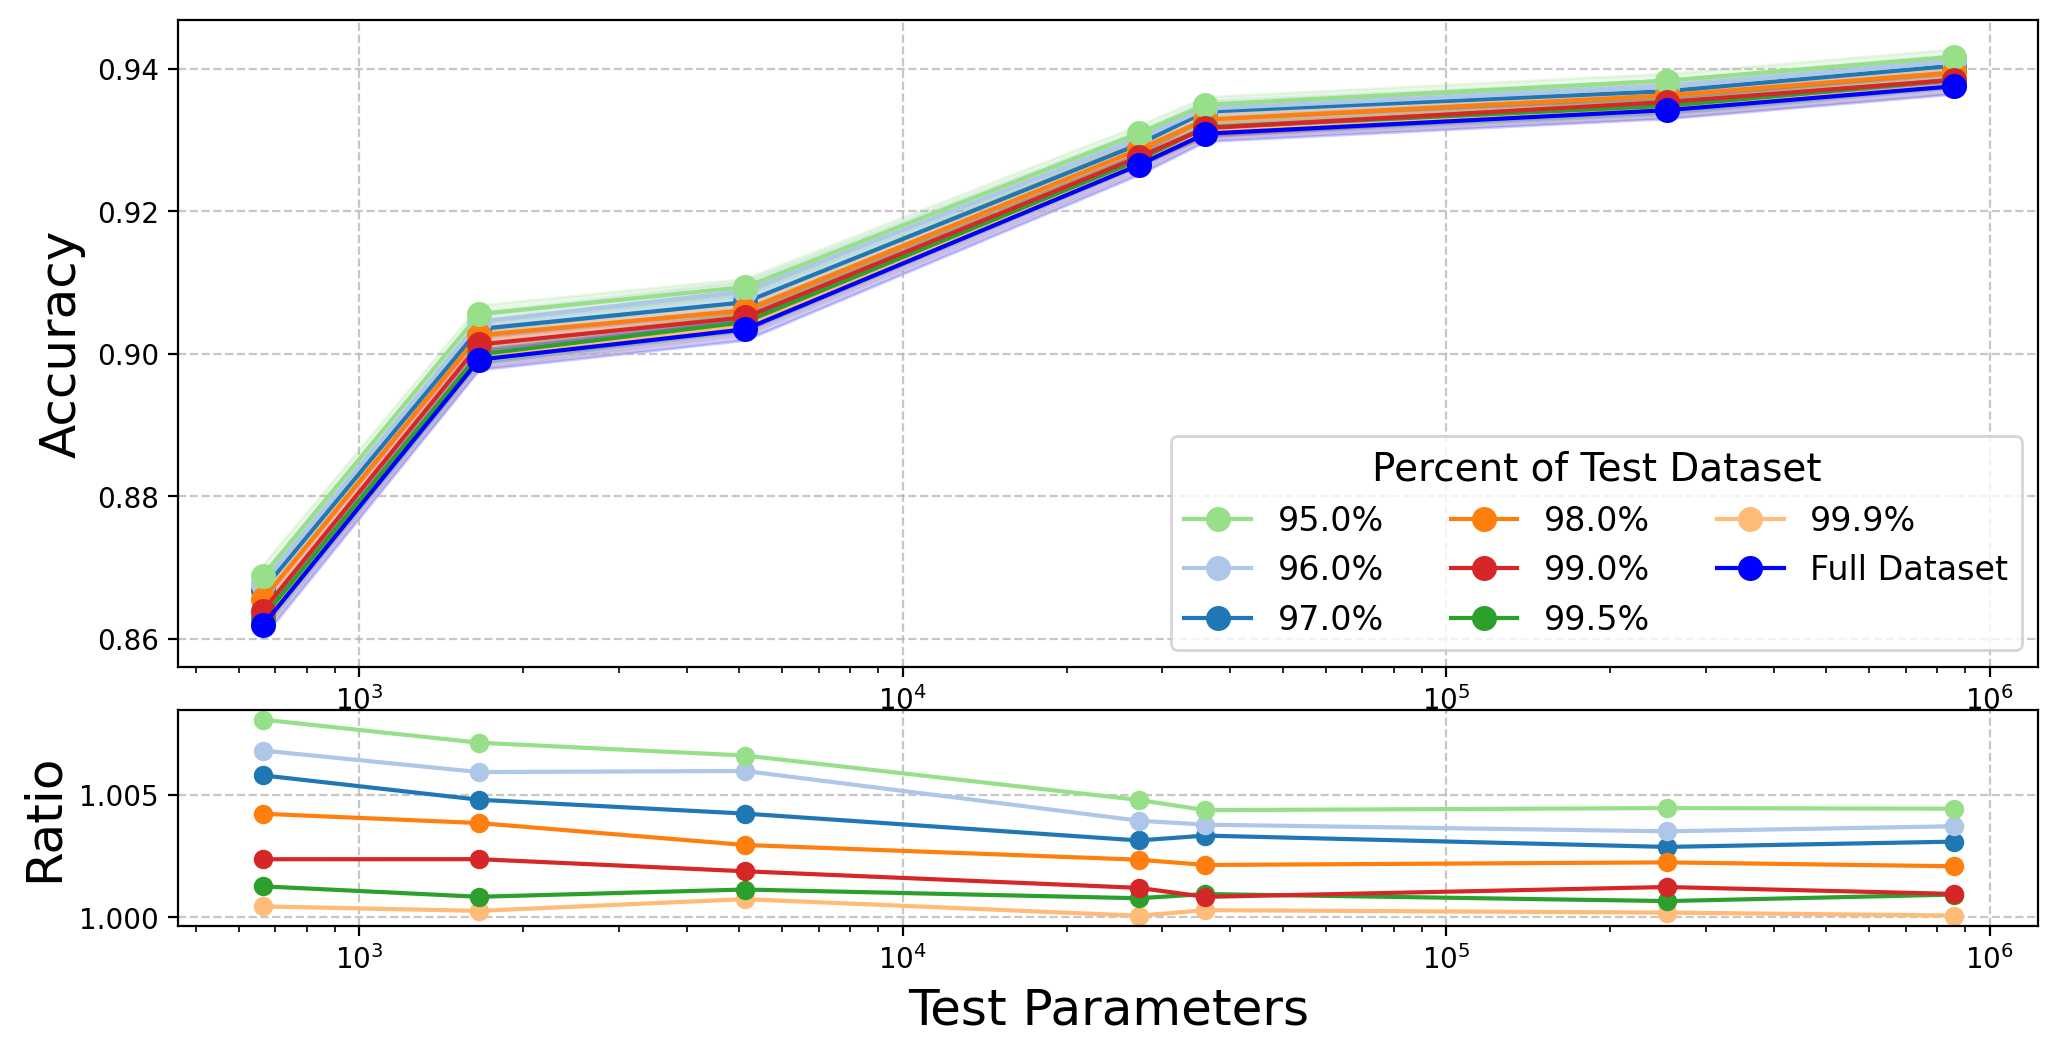

In [328]:
# Full code integrating split plot for ratio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


param_map = {
    'RxH_2_RxH_2_partD4_jetD4_layers1_nheads1': 664.0,
    'RxH_120_RxH_128_partD240_jetD256_layers4_nheads12': 1380000.0,
    'RxH_2_RxH_6_partD4_jetD12_layers2_nheads1': 1490.0,
    'RxH_4_RxH_4_partD8_jetD8_layers1_nheads1': 1660.0,
    'RxH_5_RxH_12_partD10_jetD24_layers2_nheads1': 5120.0,
    'RxH_120_RxH_128_partD240_jetD256_layers8_nheads12': 2029999.9999999998,
    'RxH_40_RxH_48_partD80_jetD96_layers8_nheads4': 254550.0,
    'RxH_10_RxH_24_partD20_jetD48_layers2_nheads1': 27160.0,
    'RxH_10_RxH_24_partD20_jetD48_layers8_nheads1': 36010.0,
    'RxH_20_RxH_32_partD40_jetD64_layers8_nheads2': 83380.0,
    'RxH_80_RxH_64_partD160_jetD128_layers8_nheads8': 858190.0
}

# Define the figure and grid specification
fig = plt.figure(figsize=(12, 6), dpi=200)
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.1)

# Main plot (accuracy vs. parameters)
ax1 = fig.add_subplot(gs[0])
cmap = plt.cm.get_cmap('tab20')
i = 0

# Iterate through gromov_output files
for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 9:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params','auc_mean','auc_std', 'accuracy_mean', 'accuracy_std','Top_rejection_30_mean','Top_rejection_30_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]


    label = f"{100 - cur_curv_percent}%"
    ax1.plot(result['params'], result['accuracy_mean'], label=label, color=cmap(i / 19), marker='o', markersize=8)
    ax1.fill_between(result['params'], 
                     result['accuracy_mean'] - result['accuracy_std'], 
                     result['accuracy_mean'] + result['accuracy_std'], 
                     color=cmap(i / 19), alpha=0.2)
    acc = result['accuracy_mean']
    print(f'{100 - cur_curv_percent}')
    print(result)
    i += 1

# Full dataset plot
full_results_df = pd.read_csv('top_PMTrans_benchmark.csv').sort_values('overall_accuracy', ascending=False)
full_results_df['base_name'] = full_results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
split_columns = full_results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
full_results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
full_results_df['layers'] = full_results_df['layers'].str[-1]
full_results_df['heads'] = full_results_df['heads'].str.split('nheads').str[1]

best_full_rows_df = full_results_df.loc[full_results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
best_full_rows_df['params'] = best_full_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

full_result = best_full_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]

full_result= full_result[(full_result['params'] != 83380.0) & (full_result['params'] <= 1000000.0) & (full_result['params'] != 1490.0)]

ax1.plot(full_result['params'], full_result['accuracy_mean'], label='Full Dataset', color='b', marker='o', markersize=8)
ax1.fill_between(full_result['params'], 
                 full_result['accuracy_mean'] - full_result['accuracy_std'], 
                 full_result['accuracy_mean'] + full_result['accuracy_std'], 
                 color='b', alpha=0.2)

# Formatting for main plot
ax1.set_xscale('log')
ax1.set_ylabel("Accuracy", fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()

# Define a sorting key
def sorting_key(hl):
    handle, label = hl
    try:
        return (0, int(label))  # Sort numeric labels by their value
    except ValueError:
        return (1, label)       # Non-numeric labels go to the bottom

# Sort handles and labels
sorted_handles_labels = sorted(zip(handles, labels), key=sorting_key)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Add sorted legend
plt.legend(sorted_handles, sorted_labels, ncol=3, 
           fontsize=12, loc='lower right',
           title = 'Percent of Test Dataset',
           title_fontsize = 14)


# plt.legend(ncol = 1,fontsize = 18,loc = 'lower right')
# plt.title(
#     r'Performance of $\mathcal{P}\mathcal{M}$-Transformer on Hyperbolicity Filtered Test Dataset',
#     fontsize=18,  # Adjust fontsize as needed
#     wrap=True     # Optional: enables auto-wrapping for long titles
# )
ax1.grid(True, linestyle="--", alpha=0.7)



# Ratio plot (below the main plot)
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Reset color iterator for consistent colors in lower plot
i = 0

for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 9:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]



    # Compute the ratio
    try:
        ratio = result['accuracy_mean'] / np.interp(result['params'], full_result['params'], full_result['accuracy_mean'])
    except Exception as e:
        print(f"Error computing ratio for {file}: {e}")
        continue

    # Plot the ratio
    ax2.plot(result['params'], ratio, label=f"{100 - cur_curv_percent}%", color=cmap(i / 19), marker='o', markersize=6)
    i += 1

# Formatting for ratio plot
ax2.set_xscale('log')
ax2.set_xlabel("Test Parameters", fontsize=18)
ax2.set_ylabel("Ratio", fontsize=18)
ax2.grid(True, linestyle="--", alpha=0.7)


# Set figure background
fig.patch.set_facecolor('white')

# Show the plot
plt.show()


In [333]:
(percents[i]/100)*(acc[i]/100)

0.09790000000000001

In [335]:
percents = [90,80,70,60,50,40,30,20,10]
acc = [94.5,95,95.5,96,96.5,96.9,97.3,97.7,97.9]
for i in range(len(percents)):
    print(percents[i])
    acc_on_removed = (0.938 - (percents[i]/100)*(acc[i]/100))/((100-percents[i])/100)
    print(acc_on_removed)

90
0.8750000000000002
80
0.8899999999999997
70
0.8983333333333332
60
0.9049999999999999
50
0.9109999999999999
40
0.9173333333333332
30
0.9229999999999999
20
0.9282499999999999
10
0.9334444444444444


In [385]:
filt_df = combined_df.loc[combined_df.index.get_level_values('particle_geom') == 'H']
filt_df = filt_df.loc[filt_df.index.get_level_values('particle_dim') == 2].sort_values(by = 'val_acc',ascending=False)

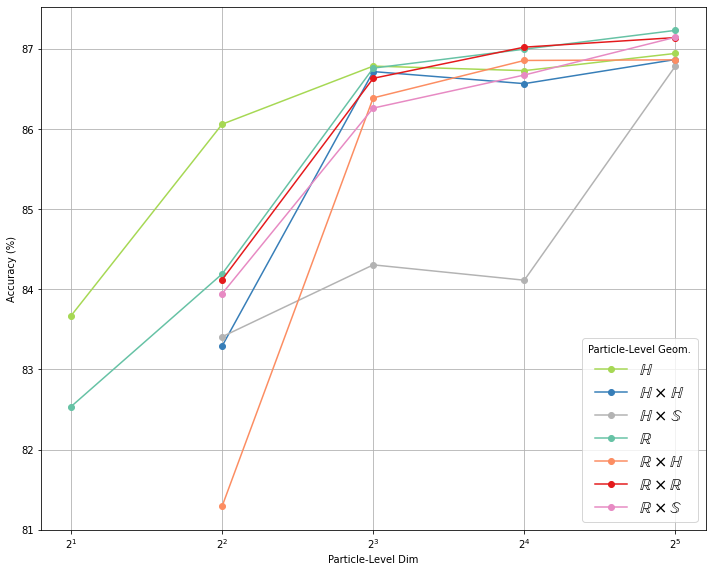

{'$\\mathbb{H}$': [Int64Index([2, 4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([83.66992188, 86.05859375, 86.78320312, 86.7265625 , 86.94140625])],
 '$\\mathbb{H} \\times \\mathbb{H}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([83.29296875, 86.71484375, 86.56445312, 86.86523438])],
 '$\\mathbb{H} \\times \\mathbb{S}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([83.40820312, 84.3046875 , 84.11328125, 86.78320312])],
 '$\\mathbb{R}$': [Int64Index([2, 4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([82.53710938, 84.19140625, 86.7578125 , 86.99414062, 87.22851562])],
 '$\\mathbb{R} \\times \\mathbb{H}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([81.29492188, 86.38671875, 86.85351562, 86.86132812])],
 '$\\mathbb{R} \\times \\mathbb{R}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([84.11914062, 86.63085938, 87.01953125, 87.13867188])],
 '$\\m

In [407]:
# path = 'JetClass_performance_summary_PMNN_h4q_neurips_for_paper'
path = 'JetClass_performance_summary_PMNN_h4q_neurips_for_paper_new_data'


combined_df = load_and_process_csv(path, term_in_file = 'h4q')
plot_highest_accuracies(combined_df,title = 'H4q tagging', 
                        variable_to_vary='particle_dim',
                        PMNN = True,metric_column='val_acc',
                        plot_best = True,
#                         acc_range = [80.5,87],
                        filter_name = ['S','SxS']
                        )


# acc_range = [80,90]

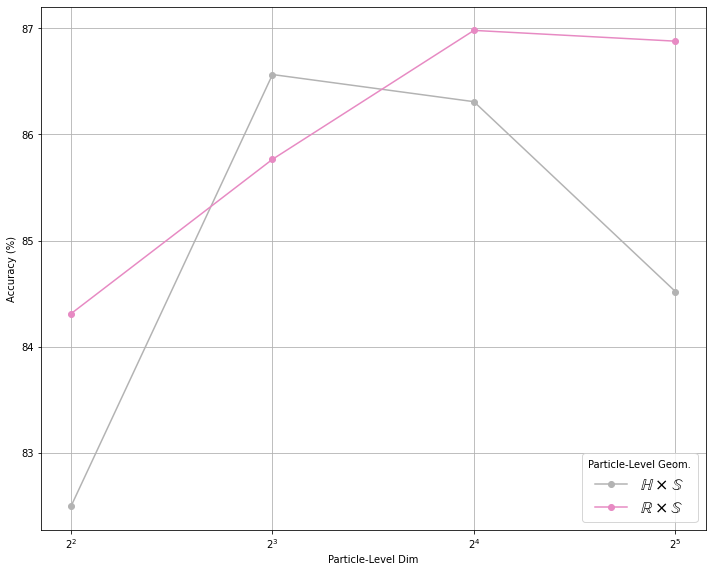

{'$\\mathbb{H} \\times \\mathbb{S}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([82.49609375, 86.56445312, 86.30859375, 84.51953125])],
 '$\\mathbb{R} \\times \\mathbb{S}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([84.31054688, 85.765625  , 86.98046875, 86.87890625])]}

In [409]:
# path = 'JetClass_performance_summary_PMNN_h4q_neurips_for_paper'
path = 'JetClass_performance_summary_PMNN_h4q_neurips_for_paper_new_data_sphere'


combined_df = load_and_process_csv(path, term_in_file = 'h4q')
plot_highest_accuracies(combined_df,title = 'H4q tagging', 
                        variable_to_vary='particle_dim',
                        PMNN = True,metric_column='val_acc',
                        plot_best = True,
#                         acc_range = [80.5,87],
                        filter_name = ['S','SxS']
                        )


# acc_range = [80,90]

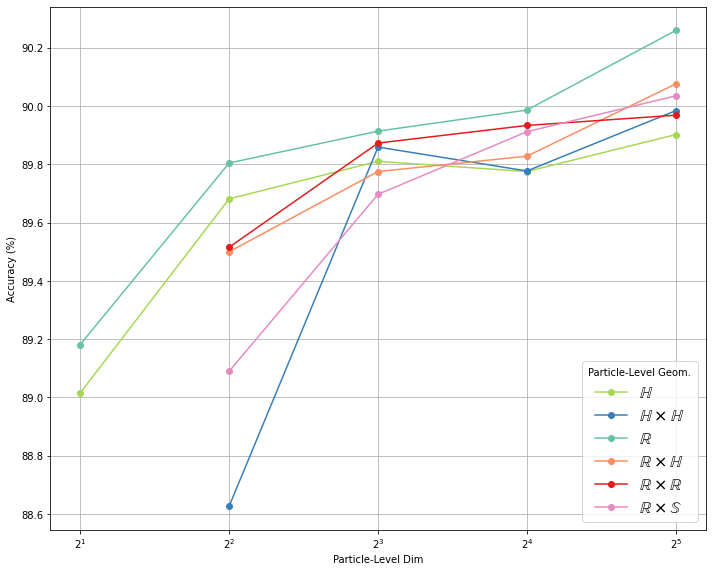

{'$\\mathbb{H}$': [Int64Index([2, 4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([89.015625  , 89.68164062, 89.81054688, 89.77539062, 89.90234375])],
 '$\\mathbb{H} \\times \\mathbb{H}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([88.62695312, 89.859375  , 89.77734375, 89.984375  ])],
 '$\\mathbb{R}$': [Int64Index([2, 4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([89.18164062, 89.8046875 , 89.9140625 , 89.98632812, 90.25976562])],
 '$\\mathbb{R} \\times \\mathbb{H}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([89.5       , 89.77539062, 89.828125  , 90.07617188])],
 '$\\mathbb{R} \\times \\mathbb{R}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([89.515625  , 89.87304688, 89.93359375, 89.96875   ])],
 '$\\mathbb{R} \\times \\mathbb{S}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([89.08984375, 89.69726562, 89.91210938, 90.03515625])]}

In [404]:
path = 'JetClass_performance_summary_PMNN_tbqq_neurips_for_paper_new_data'

combined_df = load_and_process_csv(path, term_in_file = 'tbqq')
plot_highest_accuracies(combined_df,title = 'Tbqq tagging', 
                        variable_to_vary='particle_dim',
                        PMNN = True,metric_column='val_acc',
                        plot_best = True,
                        filter_name = ['HxS','S','SxS']
#                         acc_range = [83.5,87]
                        )

# acc_range = [80,90]

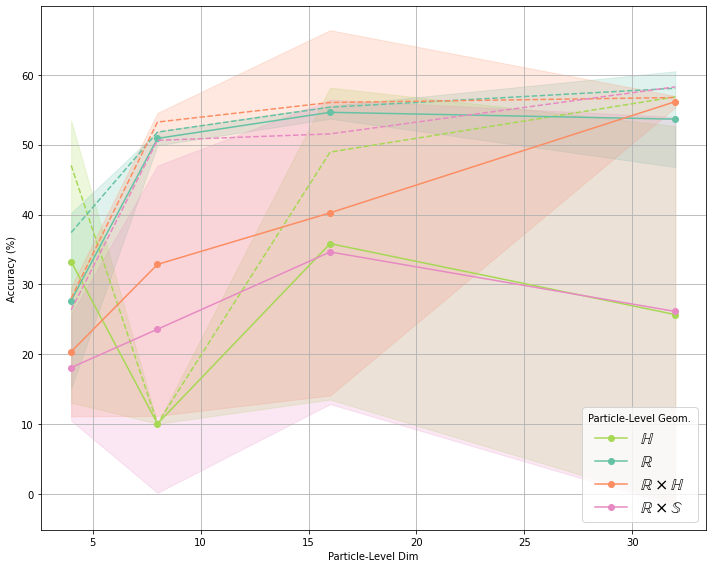

In [6]:
import pandas as pd
paths = [
         'JetClass_performance_summary_small_tuned_paper_v3_hidden']
all_df = [load_and_process_csv(path, term_in_file='final') for path in paths]
all_df = [df.reset_index() for df in all_df]
combined_df = pd.concat(all_df, ignore_index=True)
combined_df = combined_df.set_index(['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 4
}

for col, val in filter_values.items():
    if col in combined_df.index.names:
        combined_df = combined_df[combined_df.index.get_level_values(col) == val]

# Step 4: Call the plotting function
_= plot_highest_accuracies(combined_df, 
                           title='JetClass', 
                           variable_to_vary='particle_dim', 
                           filter_values=filter_values,
                           plot_trans_params = False,
                           filter_name = ['S','HxS'],
#                            acc_range = [67,73],
                           plot_best = True,
                           shaded_plot = True, 
#                            shade_by_range = True,
                           shade_by_std = True,
#                            top_3 = True, 
#                            middle_3 = True,
                           )

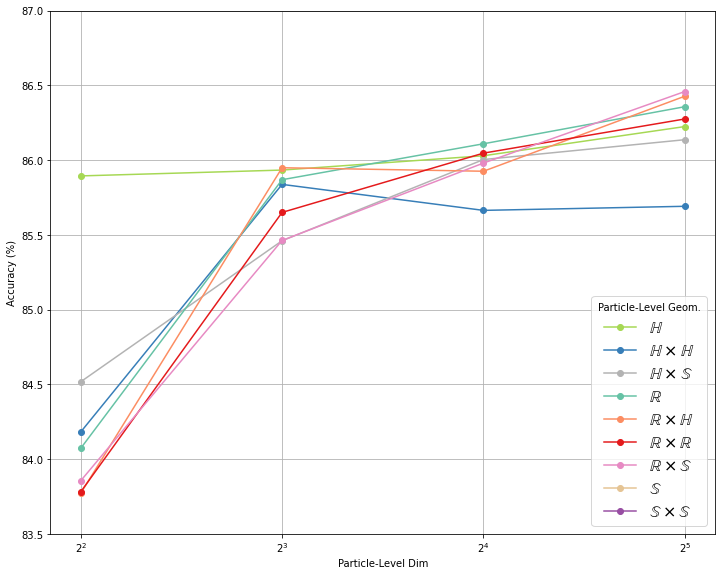

{'$\\mathbb{H}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([85.89453125, 85.93359375, 86.02929688, 86.22460938])],
 '$\\mathbb{H} \\times \\mathbb{H}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([84.18164062, 85.83789062, 85.6640625 , 85.69140625])],
 '$\\mathbb{H} \\times \\mathbb{S}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([84.51757812, 85.4609375 , 86.00390625, 86.13671875])],
 '$\\mathbb{R}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([84.07226562, 85.86914062, 86.109375  , 86.35742188])],
 '$\\mathbb{R} \\times \\mathbb{H}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([83.77148438, 85.94921875, 85.92578125, 86.42773438])],
 '$\\mathbb{R} \\times \\mathbb{R}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([83.78125   , 85.65039062, 86.046875  , 86.27539062])],
 '$\\mathbb{R} \\times \\mathbb{S}$': 

In [244]:
path = 'JetClass_performance_summary_PMNN_h4q_neurips_more_runs'

combined_df = load_and_process_csv(path, term_in_file = 'h4q')
plot_highest_accuracies(combined_df,title = 'H4q tagging', 
                        variable_to_vary='particle_dim',
                        PMNN = True,metric_column='val_acc',
                        plot_best = True,
                        acc_range = [83.5,87]
                        )

# acc_range = [80,90]

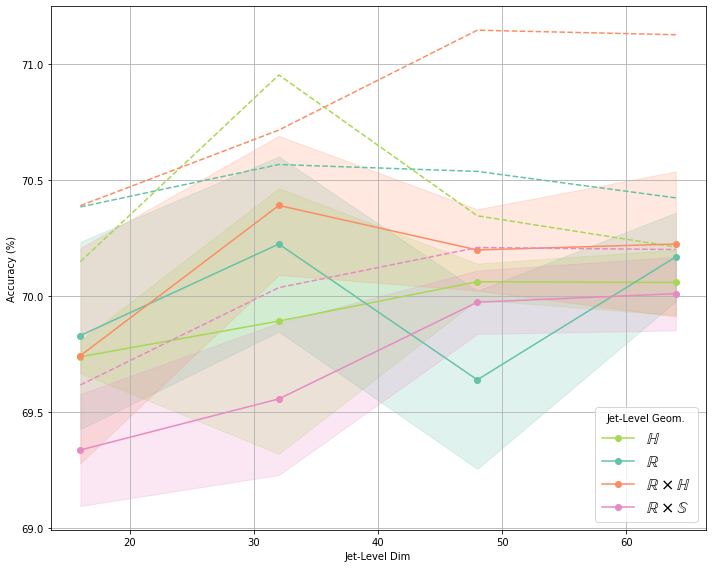

In [205]:
import pandas as pd

paths = [
         'JetClass_performance_summary_jet_lvl_v3_hidden']
all_df = [load_and_process_csv(path, term_in_file='final') for path in paths]
all_df = [df.reset_index() for df in all_df]
combined_df = pd.concat(all_df, ignore_index=True)
combined_df = combined_df.set_index(['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}

for col, val in filter_values.items():
    if col in combined_df.index.names:
        combined_df = combined_df[combined_df.index.get_level_values(col) == val]

# Step 4: Call the plotting function
_= plot_highest_accuracies(combined_df, 
                           title='JetClass', 
                           variable_to_vary='jet_dim', 
                           filter_values=filter_values,
                           plot_trans_params = False,
                           filter_name = ['S','HxS'],
#                            acc_range = [67,73],
                           plot_best = True,
                           shaded_plot = True, 
#                            shade_by_range = True,
                           shade_by_std = True,
#                            top_3 = True, 
                           middle_3 = True,
                           )

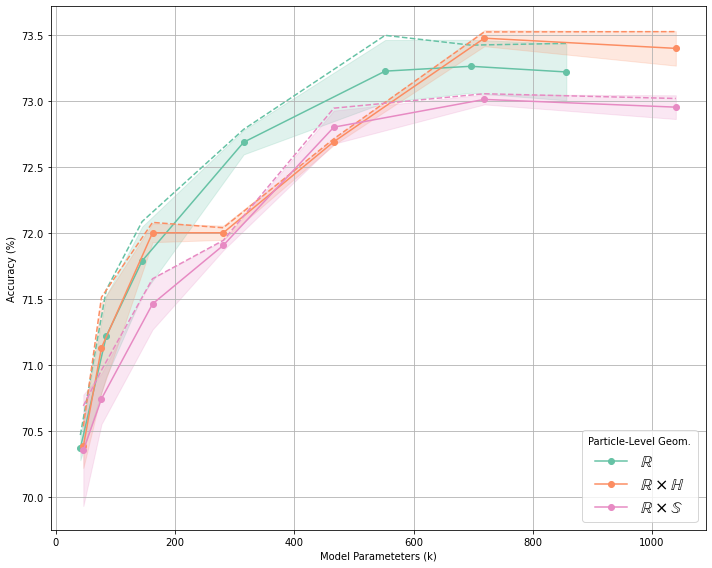

In [214]:
import pandas as pd

# paths = [
#          'JetClass_performance_summary_Euclidean_20_epochs',
#         'JetClass_performance_summary_tuned_paper_v3_hidden',
#         'JetClass_performance_summary_tuned_paper_v3_hidden_30_epochs',
#         'JetClass_performance_summary_Euclidean_30_epochs']

paths = [
         'JetClass_performance_summary_Euclidean_20_epochs',
        'JetClass_performance_summary_tuned_paper_v3_hidden',
        'JetClass_performance_summary_Euclidean_30_epochs_paper',
        'JetClass_performance_summary_tuned_paper_v3_hidden_30_epochs']

all_df = [load_and_process_csv(path, term_in_file='final') for path in paths]
all_df = [df.reset_index() for df in all_df]

combined_df = pd.concat(all_df, ignore_index=True)
combined_df = combined_df.set_index(['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])

filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}

for col, val in filter_values.items():
    if col in combined_df.index.names:
        combined_df = combined_df[combined_df.index.get_level_values(col) == val]

# Step 4: Call the plotting function
_= plot_highest_accuracies(combined_df, 
                           title='JetClass', 
                           variable_to_vary='particle_dim', 
                           filter_values={},
                           plot_trans_params = True,
                           plot_best = True,
                           shaded_plot = True, 
#                            shade_by_range = True,
                           shade_by_std = True,
                           top_3 = True, 
#                            middle_3 = True, 
                           filter_name = ['RxR','HxS'])

/tmp/ipykernel_127344/2841560811.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)
/tmp/ipykernel_127344/2841560811.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)


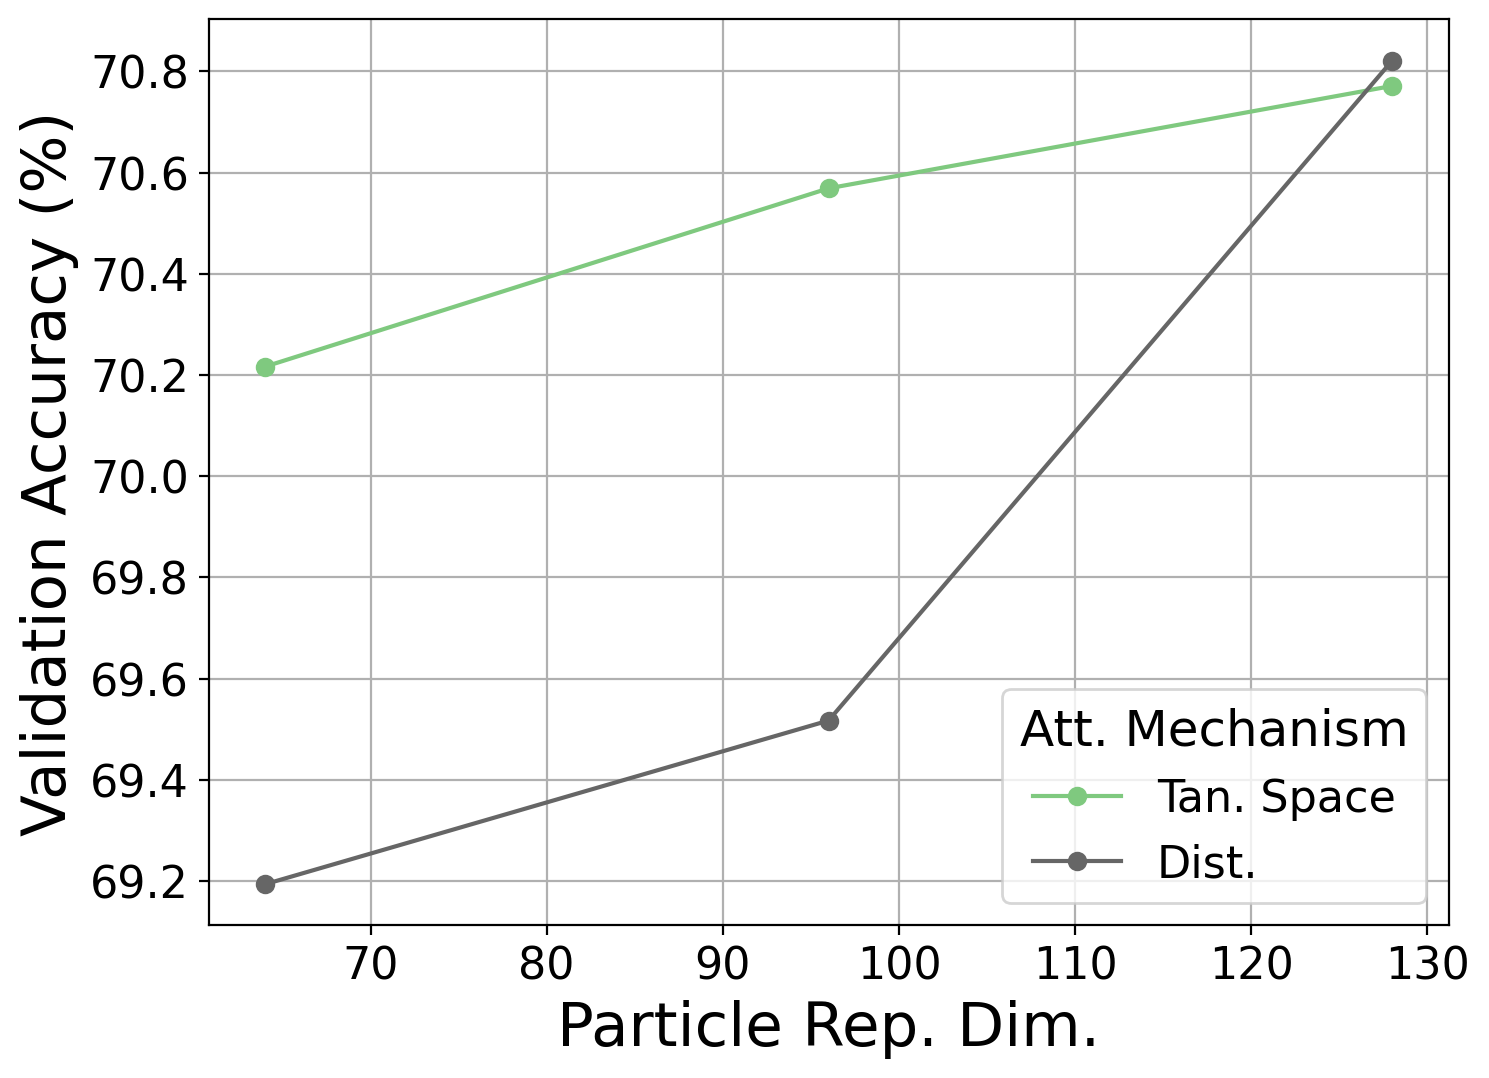

In [27]:
path = 'JetClass_performance_summary_paper_attention_comparison_dist'
combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
out_data = plot_highest_accuracies(combined_df,
                                   title = 'JetClass',
                                   variable_to_vary='particle_dim',
                                   filter_values=filter_values,
                                   hide_fig=True)

dist_data = list(out_data.values())[0]

path = 'JetClass_performance_summary_paper_attention_comparison_tanspace'
combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
out_data = plot_highest_accuracies(combined_df,
                                   title = 'JetClass',
                                   variable_to_vary='particle_dim',
                                   filter_values=filter_values,
                                   hide_fig=True)
tan_space_data = list(out_data.values())[0]

colormap = plt.get_cmap('Accent', 2)  # 'viridis' is an example


plt.figure(figsize=(8,6), dpi = 200)
plt.plot(tan_space_data[0],tan_space_data[1],label = 'Tan. Space',marker='o',color=colormap(0))
plt.plot(dist_data[0],dist_data[1], label = 'Dist.',marker='o', color = colormap(1))
plt.legend(title = 'Att. Mechanism',title_fontsize = 18,  fontsize=16, loc='lower right')
plt.tick_params(axis='x', labelsize=16)  # X-axis
plt.tick_params(axis='y', labelsize=16)
plt.ylabel('Validation Accuracy (%)', fontsize = 22)
plt.xlabel('Particle Rep. Dim.',fontsize = 22)
plt.grid(True)
plt.show()

/tmp/ipykernel_127344/2841560811.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)
/tmp/ipykernel_127344/2841560811.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)
/tmp/ipykernel_127344/2841560811.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)


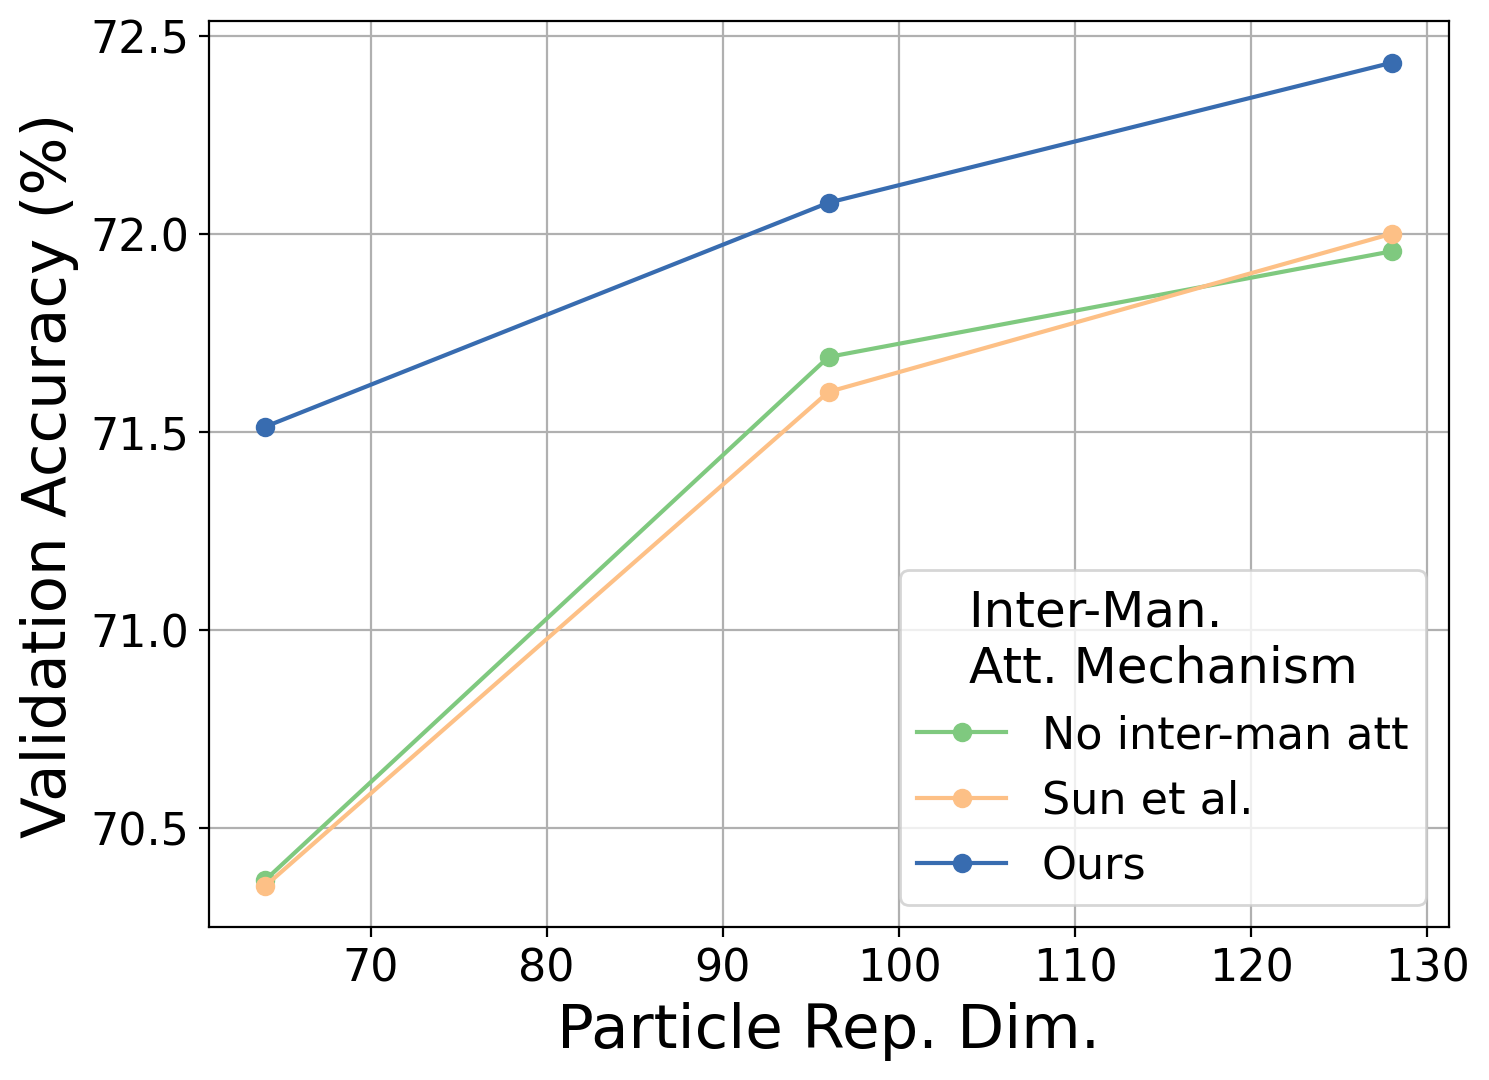

In [28]:
path = 'JetClass_performance_summary_paper_comparison_inter_man_none'

combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
out_data = plot_highest_accuracies(combined_df,
                                   title = 'JetClass',
                                   variable_to_vary='particle_dim',
                                   filter_values=filter_values,
                                   hide_fig=True)

no_att_data = list(out_data.values())[0]

path = 'JetClass_performance_summary_paper_comparison_inter_man_v1'
combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
out_data = plot_highest_accuracies(combined_df,
                                   title = 'JetClass',
                                   variable_to_vary='particle_dim',
                                   filter_values=filter_values,
                                   hide_fig=True)
v1_data = list(out_data.values())[0]

path = 'JetClass_performance_summary_tuned_paper_v3_hidden'
combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
out_data = plot_highest_accuracies(combined_df,
                                   title = 'JetClass',
                                   variable_to_vary='particle_dim',
                                   filter_values=filter_values,
                                   hide_fig=True)
v2_data = list(out_data.values())[1]

colormap = plt.get_cmap('Accent', 5)  # 'viridis' is an example


plt.figure(figsize=(8,6),dpi =200)
plt.plot(no_att_data[0],no_att_data[1],label = 'No inter-man att',marker='o',c= colormap(0))
plt.plot(v1_data[0],v1_data[1],label = 'Sun et al. ',marker='o', c= colormap(1))
plt.plot(v2_data[0][1:-1],v2_data[1][1:-1],label = 'Ours',marker='o', c= colormap(2))
plt.legend(title = 'Inter-Man. \nAtt. Mechanism',title_fontsize = 18,  fontsize=16, loc='lower right')
plt.tick_params(axis='x', labelsize=16)  # X-axis
plt.tick_params(axis='y', labelsize=16)
plt.ylabel('Validation Accuracy (%)', fontsize = 22)
plt.xlabel('Particle Rep. Dim.',fontsize = 22)
plt.grid(True)
plt.show()

In [470]:
# Function to calculate metrics for each class
def calculate_metrics(y_true, y_scores, target_tprs=[0.5, 0.7, 0.99]):
    unique_classes = np.unique(y_true)
    aucs = {}
    accuracies = {}
    rejections = {tpr: {} for tpr in target_tprs}
    fprs = {}
    tprs = {}

    for class_label in unique_classes:
        binary_y_true = (y_true == class_label).astype(int)
        y_score = y_scores[:, class_label]

        if len(np.unique(binary_y_true)) < 2:
            aucs[class_label] = None
            accuracies[class_label] = None
            for tpr in target_tprs:
                rejections[tpr][class_label] = None
            fprs[class_label] = None
            tprs[class_label] = None
            continue

        fpr, tpr, thresholds = roc_curve(binary_y_true, y_score)
        auc = roc_auc_score(binary_y_true, y_score)
        accuracy = accuracy_score(binary_y_true, y_score >= 0.5)
        
        rejections_for_class = {}
        for tpr_value in target_tprs:
            if tpr_value in tpr:
                target_index = np.where(tpr >= tpr_value)[0][0]
                target_fpr = fpr[target_index]
                rejections_for_class[tpr_value] = 1 / target_fpr if target_fpr != 0 else np.inf
            else:
                rejections_for_class[tpr_value] = None
        
        aucs[class_label] = auc
        accuracies[class_label] = accuracy
        for tpr in target_tprs:
            rejections[tpr][class_label] = rejections_for_class[tpr]
        
        # Check if fpr and tpr are lists before converting them
        fprs[class_label] = fpr.tolist() if isinstance(fpr, (list, np.ndarray)) else []
        tprs[class_label] = tpr.tolist() if isinstance(tpr, (list, np.ndarray)) else []

    return aucs, accuracies, rejections, fprs, tprs


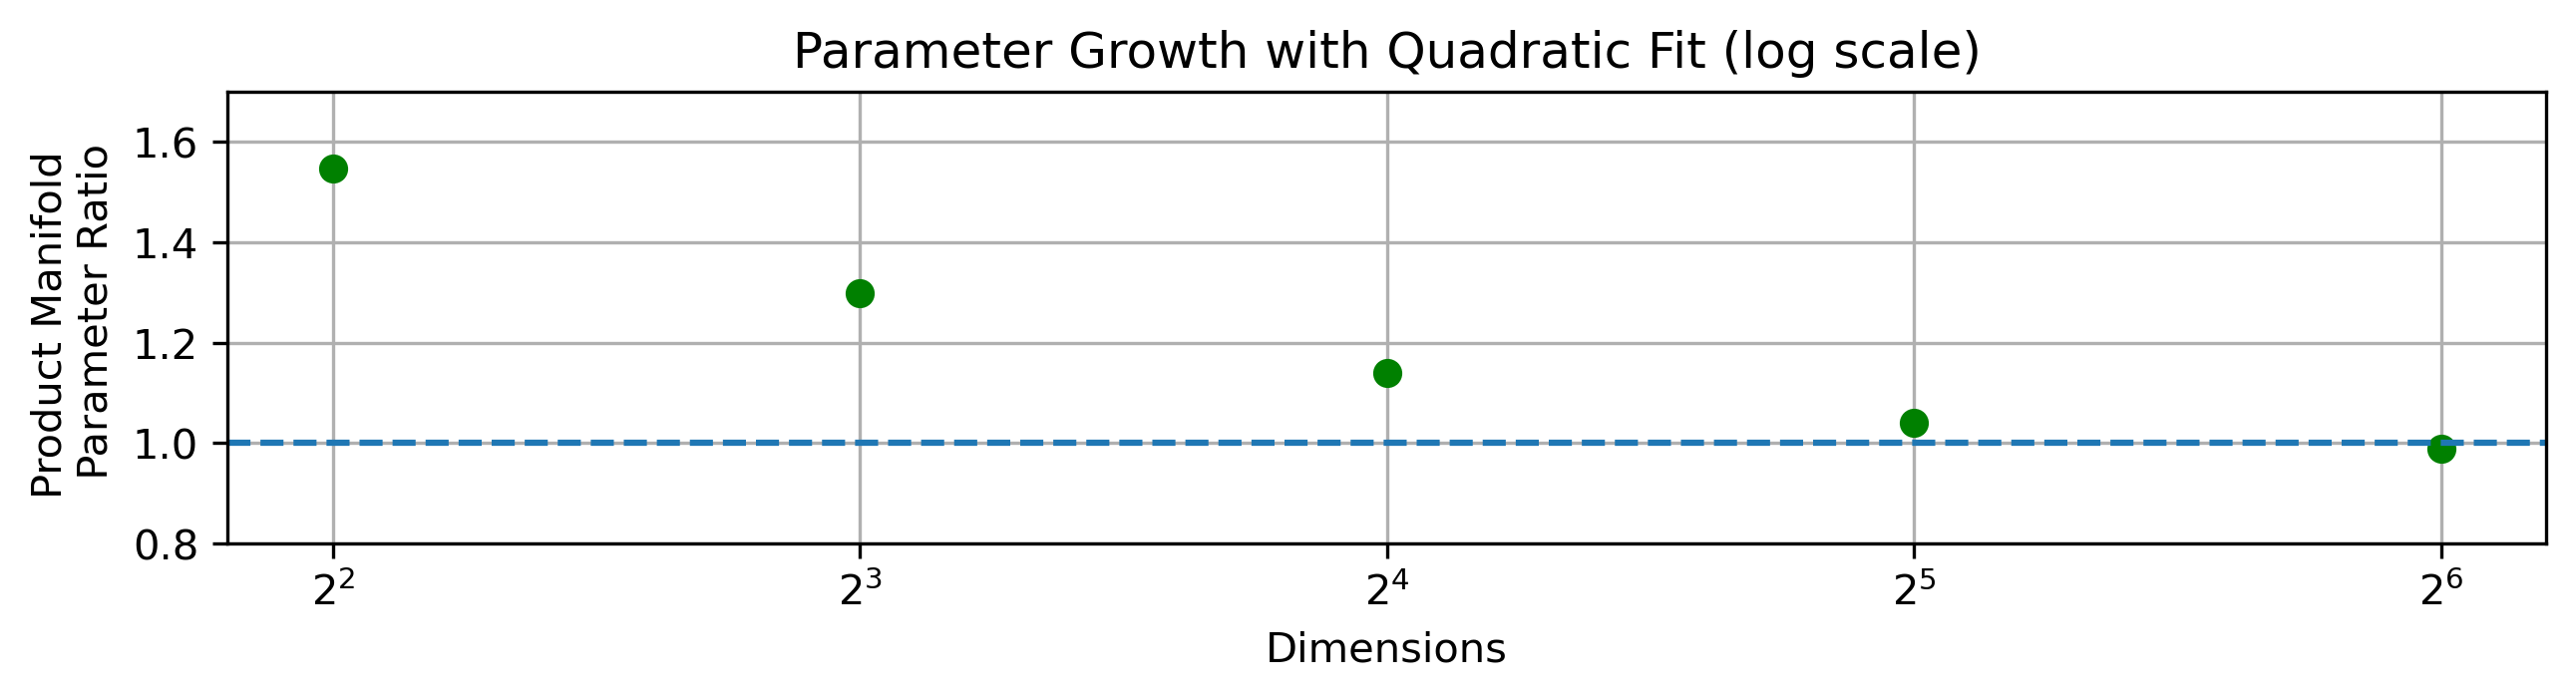

In [649]:
# total_dims = [4,8,16,32,64,128,256]
# prod_man_params = [243,357,705, 1810,5650,19860,74390]
# single_man_params = [157, 275,619, 1740, 5710,20550, 77900]

total_dims = [4,8,16,32,64]
prod_man_params = [243,357,705, 1810,5650]
single_man_params = [157, 275,619, 1740, 5710]


# Convert to log base 2 for the x-axis
log_total_dims = total_dims

# Fit quadratic models (2nd degree polynomial) for both data sets
prod_fit = np.polyfit(log_total_dims, prod_man_params, 2)
single_fit = np.polyfit(log_total_dims, single_man_params, 2)

# Generate x values for the plot up to dimension 512
x_vals = np.array([4, 8, 16, 32, 64, 128, 256, 512])

# Calculate the fitted quadratic curves
prod_quad_fit = np.polyval(prod_fit, x_vals)
single_quad_fit = np.polyval(single_fit, x_vals)

# Plotting the data and the fits
plt.figure(figsize=(10, 2),dpi = 300)
# plt.plot(log_total_dims, prod_man_params, 'o', label='Prod Manifold Params', color='blue')
plt.plot(log_total_dims, np.array(prod_man_params)/np.array(single_man_params), 'o', label='Single Manifold Params', color='green')

# # Plot the quadratic fits
# plt.plot(x_vals, prod_quad_fit, '--', label='Prod Manifold Fit', color='blue')
# plt.plot(x_vals, single_quad_fit, '--', label='Single Manifold Fit', color='green')

# Set log scale for y-axis
# plt.yscale('log',base = 10)
plt.xscale('log',base = 2)
plt.axhline(1,linestyle='--')
plt.ylim(0.8,1.7)
# plt.xlim()

# Set labels and title
plt.xlabel('Dimensions')
plt.ylabel('Product Manifold \n Parameter Ratio')
plt.title('Parameter Growth with Quadratic Fit (log scale)')

# Add legend
# plt.legend()

# Show plot
plt.grid(True)
plt.show()